# Preparation and Data Loading

## Environment Setup

In [1]:
# Use this only for the final pdf generation
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==1.26.4 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


## Loading data

In [4]:
# Loading cell-gene matrices:
adata_10x = sc.read_10x_mtx('../../data/downstream/matrices/brain/10x/')
adata_final = sc.read_10x_mtx('../../data/downstream/matrices/brain/final/')

In [5]:
print(adata_10x.X.sum())
print(adata_final.X.sum())
print(adata_final.X[:, adata_final.var_names.str.startswith("INTERGENIC")].sum())

107214184.0
114838380.0
2031776.0


In [6]:
adata_10x.var_names_make_unique()
adata_final.var_names_make_unique()
print(adata_10x)
print(adata_final)

AnnData object with n_obs × n_vars = 6794880 × 38593
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 3912523 × 40884
    var: 'gene_ids', 'feature_types'


In [7]:
adata_10x.raw = adata_10x.copy()
adata_final.raw = adata_final.copy()

# Quality control

Firstly let's compute various metrics, which we will later use

In [8]:
# Geting various metrics, including amount mitochondrial, ribosomal and hemoglobin genes:
adata_10x.var['mt'] = adata_10x.var_names.str.startswith('MT')
adata_10x.var["ribo"] = adata_10x.var_names.str.startswith(("RPS", "RPL"))
adata_10x.var["hb"] = adata_10x.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_10x, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

adata_final.var['mt'] = adata_final.var_names.str.startswith('MT')
adata_final.var["ribo"] = adata_final.var_names.str.startswith(("RPS", "RPL"))
adata_final.var["hb"] = adata_final.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata_final, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=True, inplace=True)

## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

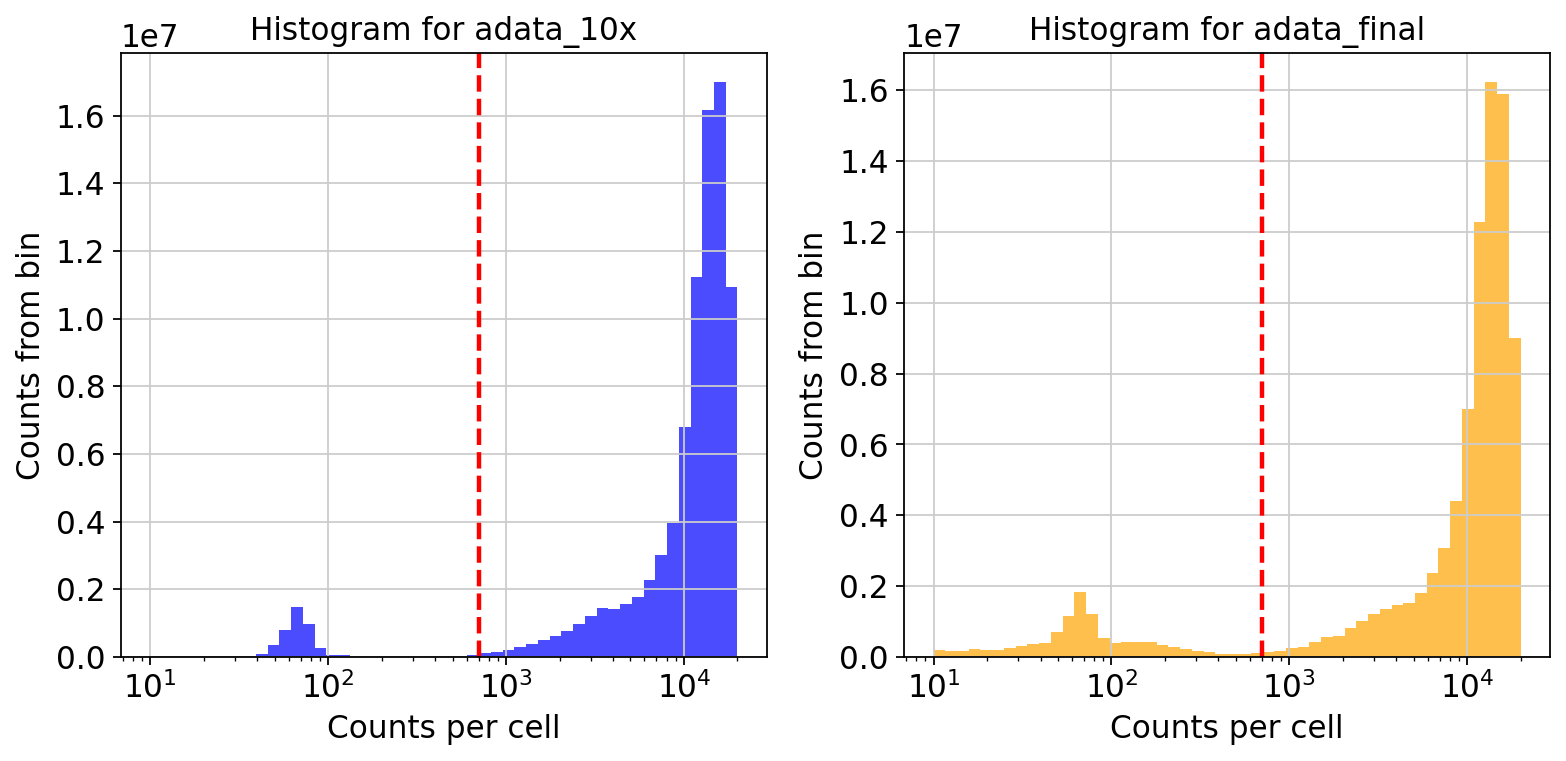

In [9]:
# Define bins
bins = np.logspace(np.log10(10), np.log10(20000), 51)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First subplot: adata_10x
axs[0].hist(
    adata_10x.obs["total_counts"], bins=bins, weights=adata_10x.obs["total_counts"],
    color="blue", alpha=0.7
)
axs[0].set_xscale('log')
axs[0].set_ylabel("Counts from bin")
axs[0].set_xlabel("Counts per cell")
axs[0].set_title("Histogram for adata_10x")
axs[0].axvline(x=700, color='red', linestyle='dashed', linewidth=2)

# Second subplot: adata_final
axs[1].hist(
    adata_final.obs["total_counts"], bins=bins, weights=adata_final.obs["total_counts"],
    color="orange", alpha=0.7
)
axs[1].set_xscale('log')
axs[1].set_ylabel("Counts from bin")
axs[1].set_xlabel("Counts per cell")
axs[1].set_title("Histogram for adata_final")
axs[1].axvline(x=700, color='red', linestyle='dashed', linewidth=2)

# Adjust layout and display
plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [10]:
cmask = adata_10x.obs['total_counts'].values>700
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['total_counts'].values>700
adata_final = adata_final[cmask]

Filtering low expression genes:

In [11]:
# Filtering low expression genes:
sc.pp.filter_genes(adata_10x, min_cells=3)
sc.pp.filter_genes(adata_final, min_cells=3)

In [12]:
print(adata_10x.shape)
print(adata_final.shape)

(10524, 29328)
(10604, 32253)


Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [13]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [14]:
adata_10x.obs["outlier"] = (
    is_outlier(adata_10x, "log1p_total_counts", 5)
    | is_outlier(adata_10x, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_10x, "pct_counts_mt", 3)
    | (adata_10x.obs["pct_counts_mt"] > 10)
)

adata_final.obs["outlier"] = (
    is_outlier(adata_final, "log1p_total_counts", 5)
    | is_outlier(adata_final, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata_final, "pct_counts_mt", 3)
    | (adata_final.obs["pct_counts_mt"] > 10)
)

In [15]:
print(f"Total number of cells: {adata_10x.n_obs}")
adata_10x = adata_10x[(~adata_10x.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_10x.n_obs}")

Total number of cells: 10524
Number of cells after filtering of low quality cells: 9252


In [16]:
print(f"Total number of cells: {adata_final.n_obs}")
adata_final = adata_final[(~adata_final.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata_final.n_obs}")

Total number of cells: 10604
Number of cells after filtering of low quality cells: 9398


## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [17]:
sc.external.pp.scrublet(adata_10x)
sc.external.pp.scrublet(adata_final)

In [18]:
cmask = adata_10x.obs['predicted_doublet'].values == False
adata_10x = adata_10x[cmask]

cmask = adata_final.obs['predicted_doublet'].values == False
adata_final = adata_final[cmask]

In [19]:
print(adata_10x.shape)
print(adata_final.shape)

(9252, 29328)
(9398, 32253)


In [20]:
adata_10x.layers["celltypist"] = adata_10x.X
adata_final.layers["celltypist"] = adata_final.X

In [21]:
print(len([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]))

2210


## Visualisation

Plotting highest expression genes:

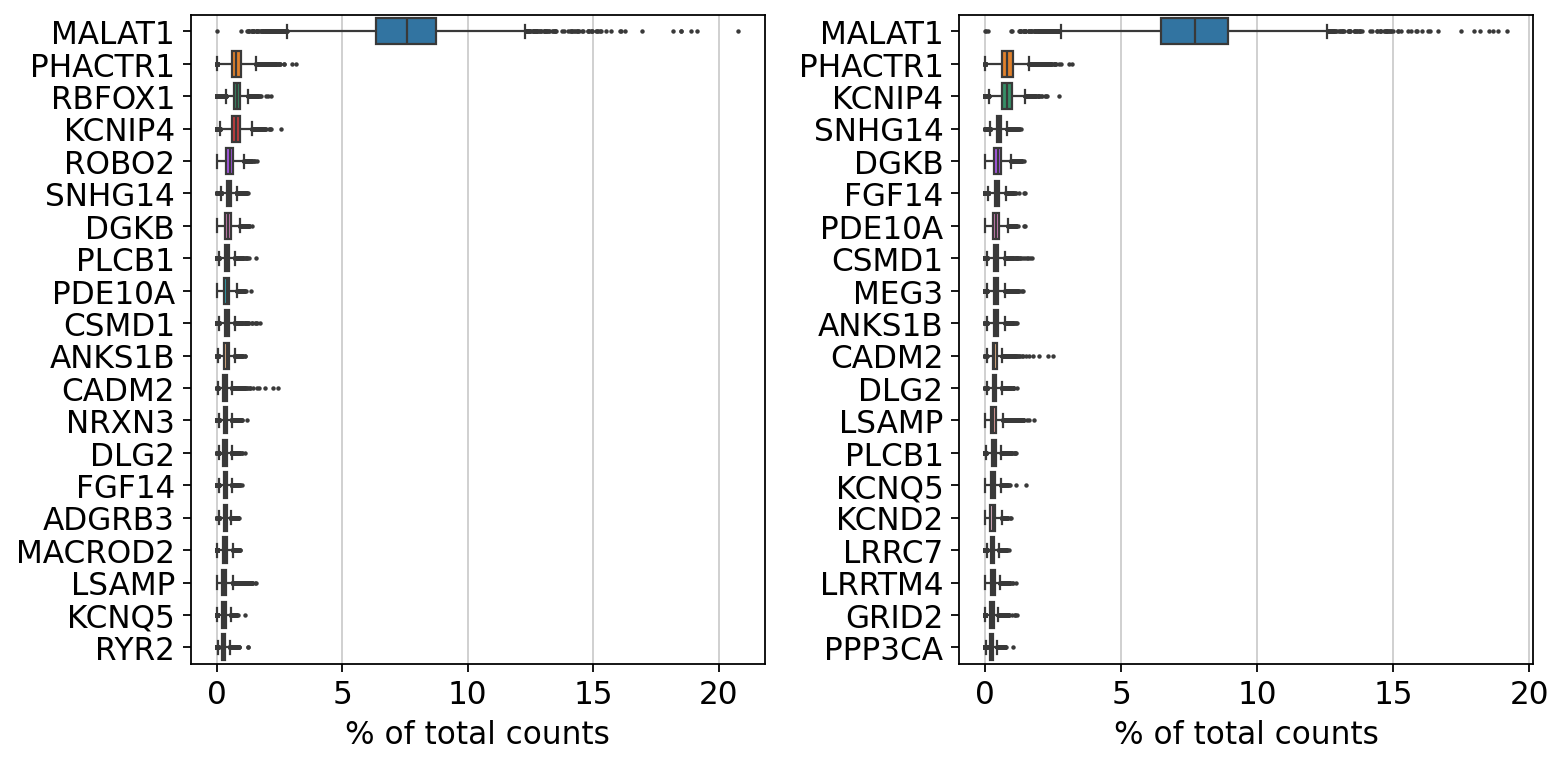

In [22]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sc.pl.highest_expr_genes(adata_10x, n_top=20, ax = axs[0], show = False)

sc.pl.highest_expr_genes(adata_final, n_top=20, ax = axs[1], show = False)

plt.tight_layout()
plt.show()

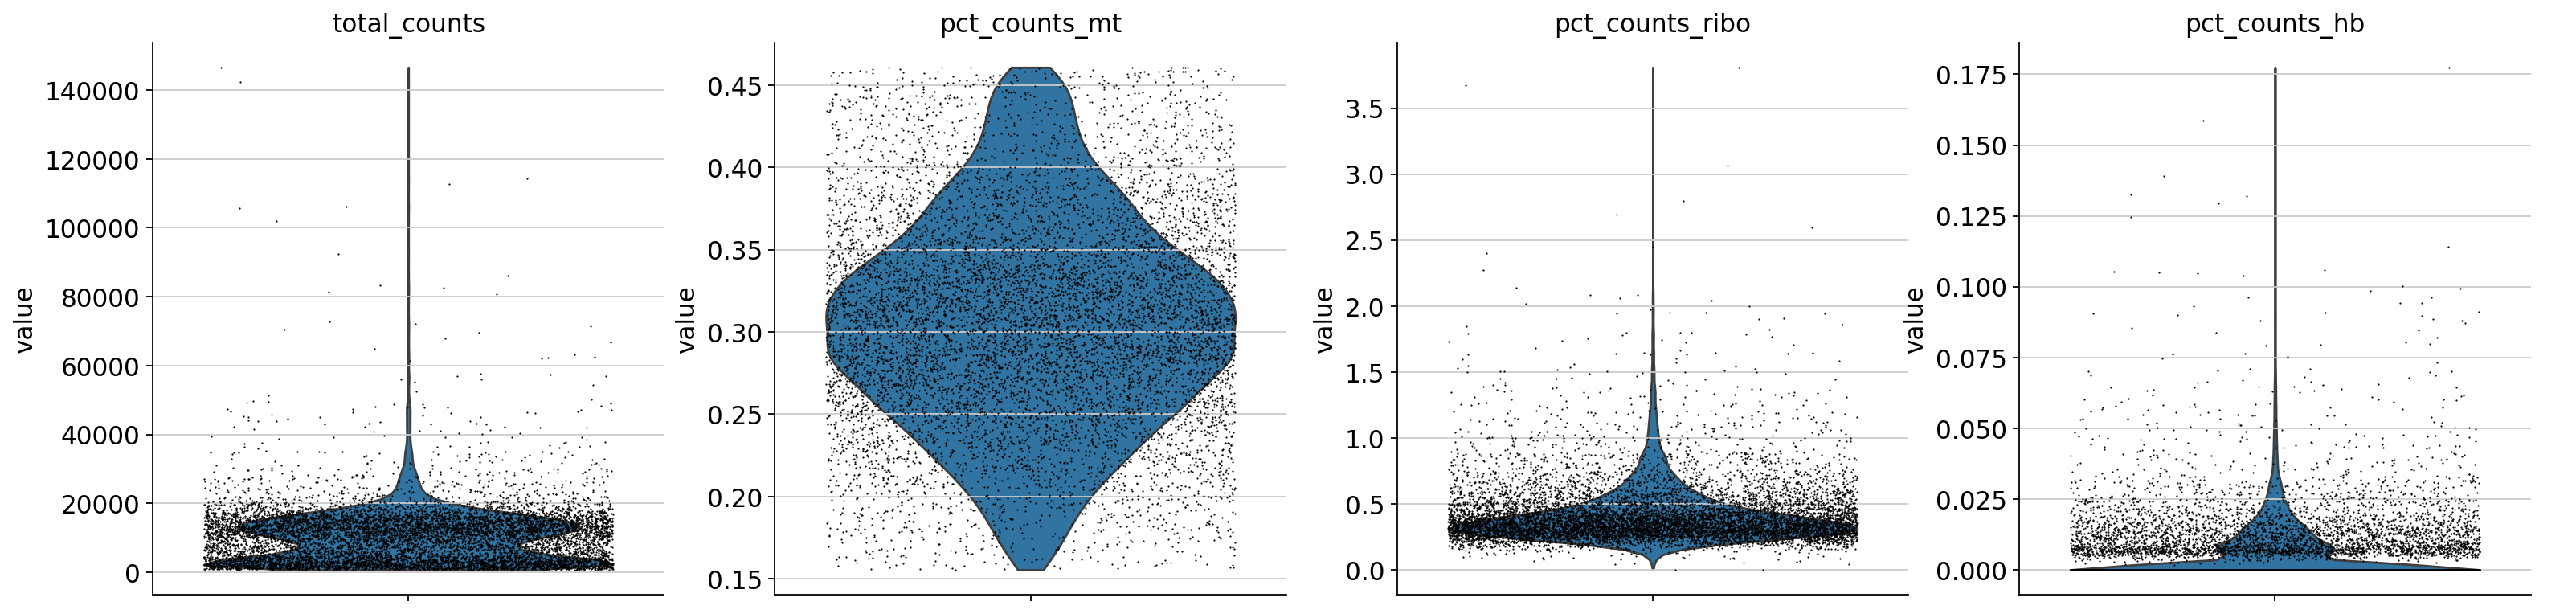

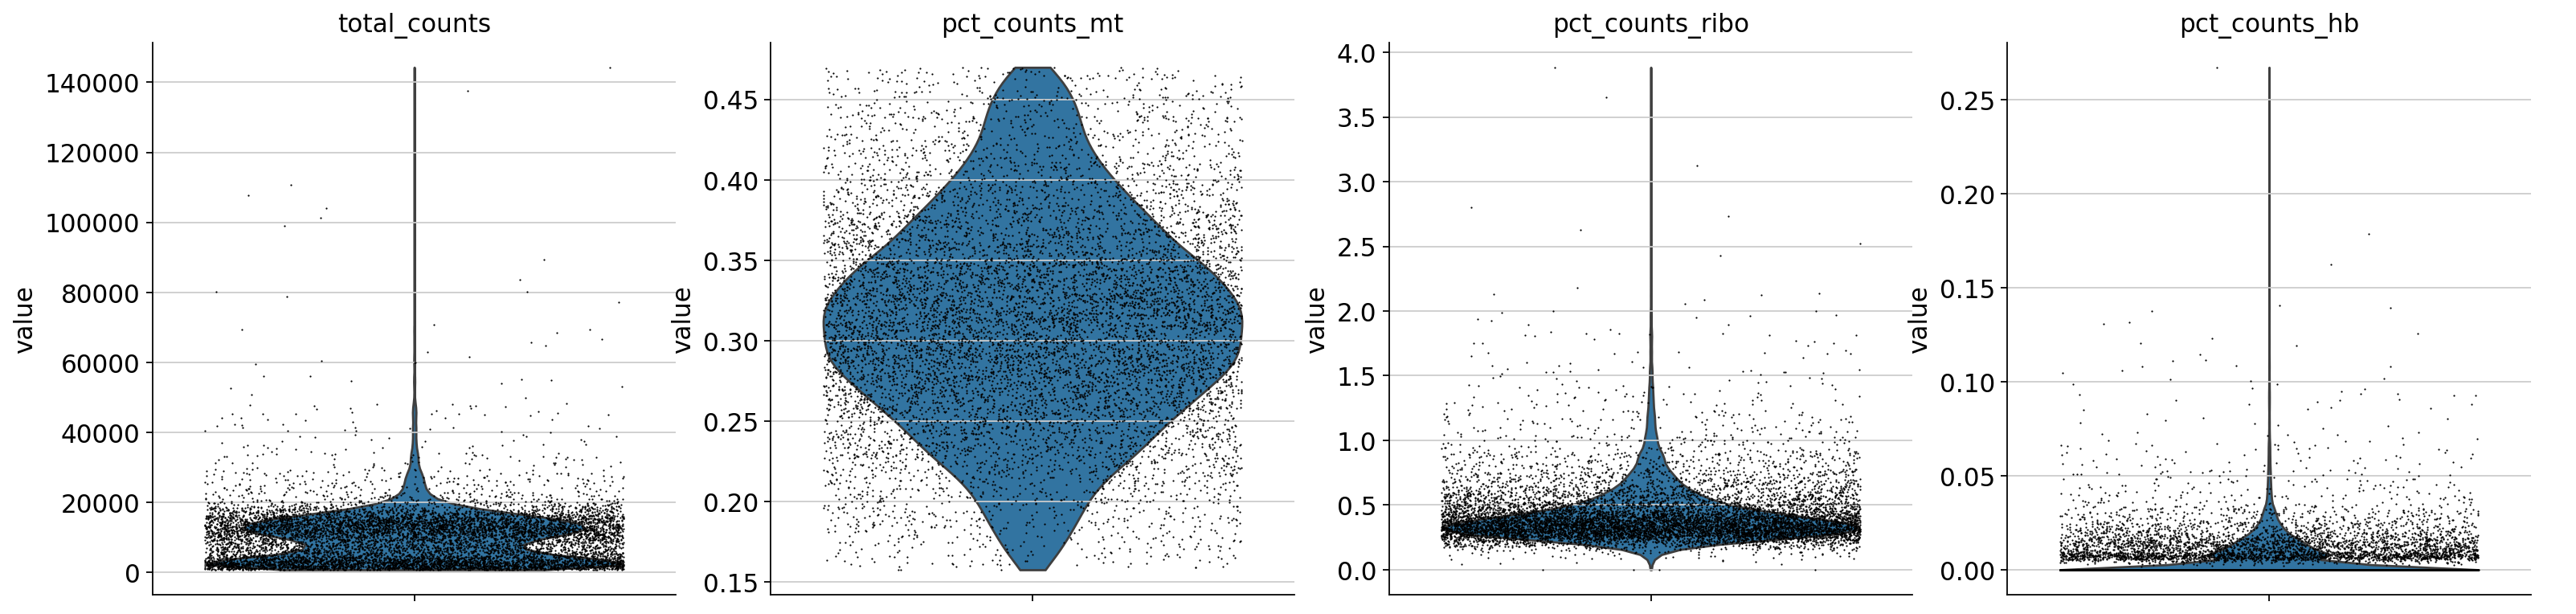

In [23]:
sc.pl.violin(adata_10x, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)
sc.pl.violin(adata_final, keys=['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'], jitter=0.4, multi_panel=True)

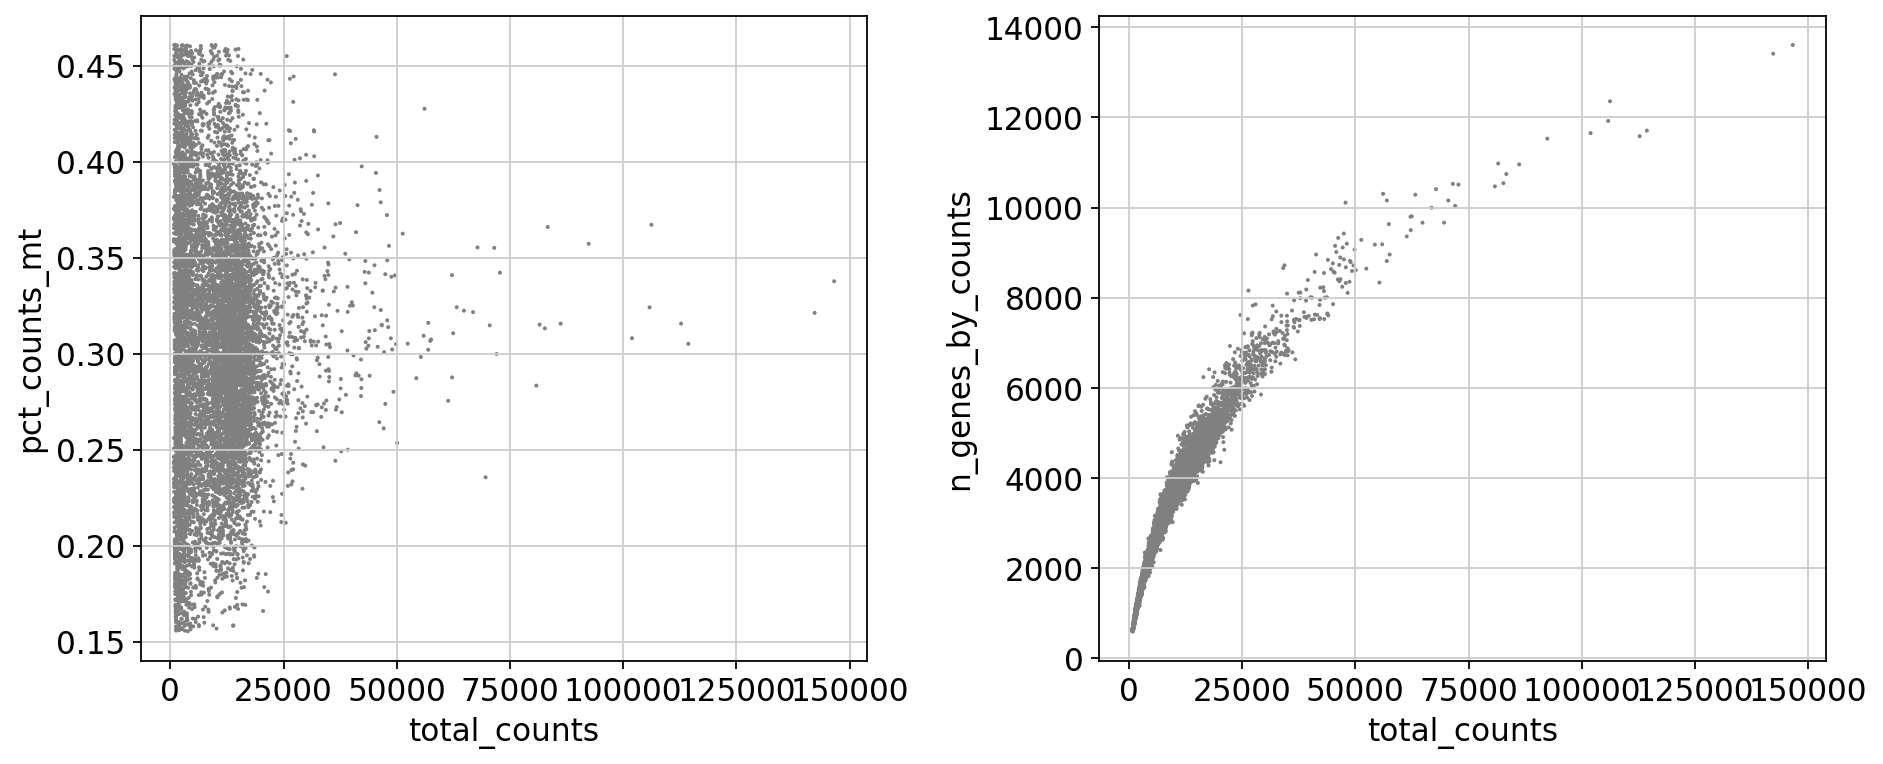

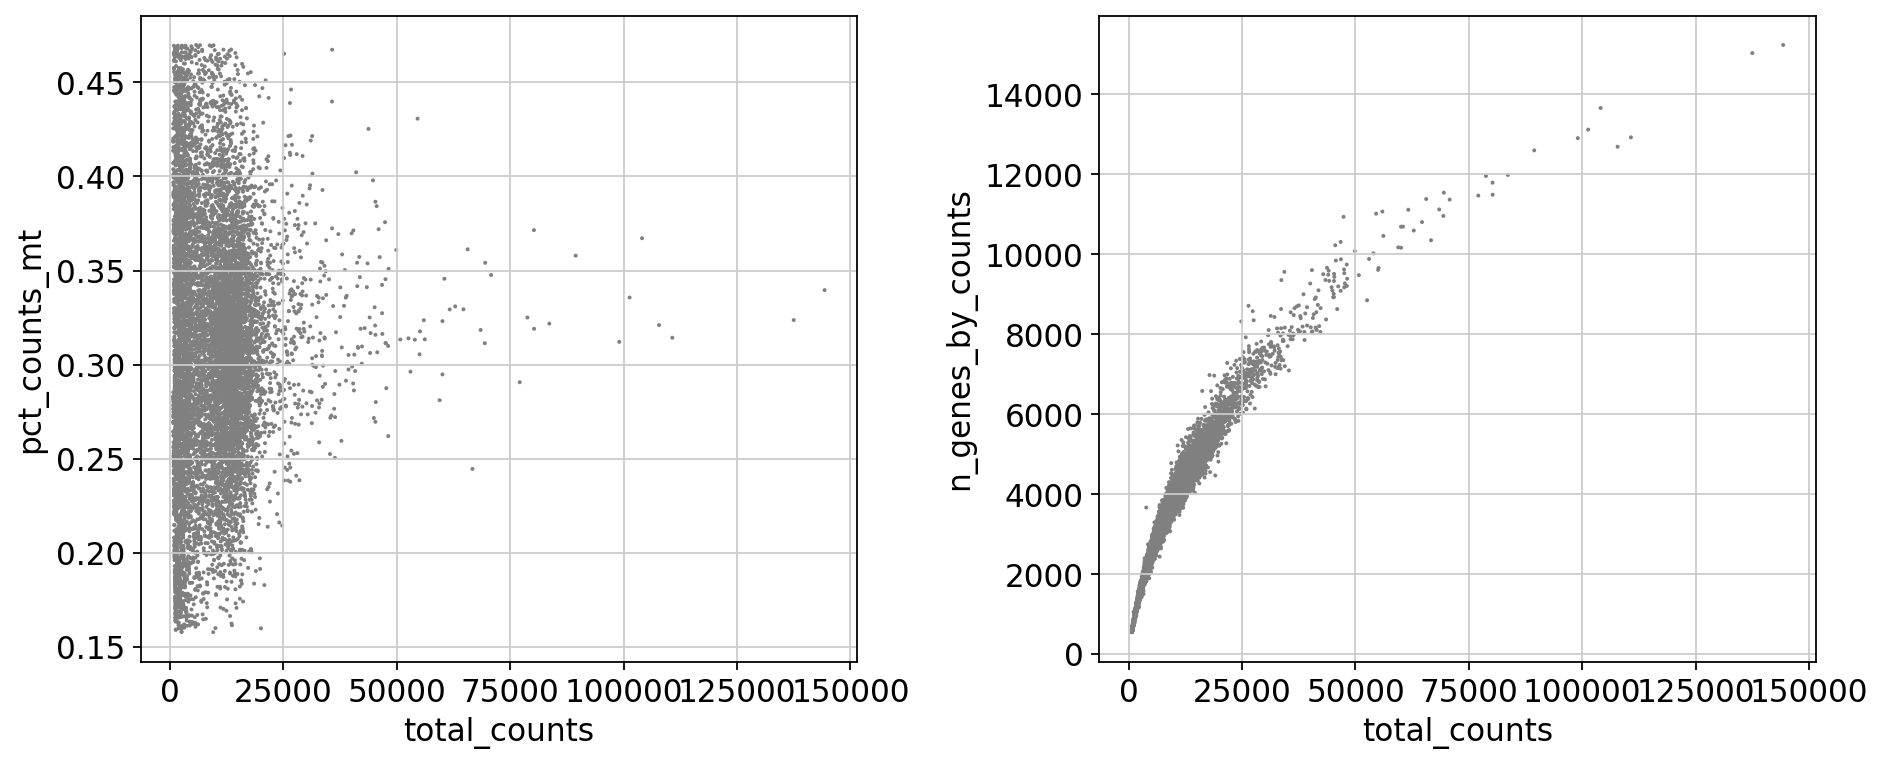

In [24]:
figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_10x, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_10x, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

figure, axs = plt.subplots(1,2, figsize=(12,5))

sc.pl.scatter(adata_final, x='total_counts', y='pct_counts_mt', ax=axs[0], show=False)
sc.pl.scatter(adata_final, x='total_counts', y='n_genes_by_counts', ax=axs[1], show=False)

plt.tight_layout()
plt.show()

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

Before normalization (adata_10x):


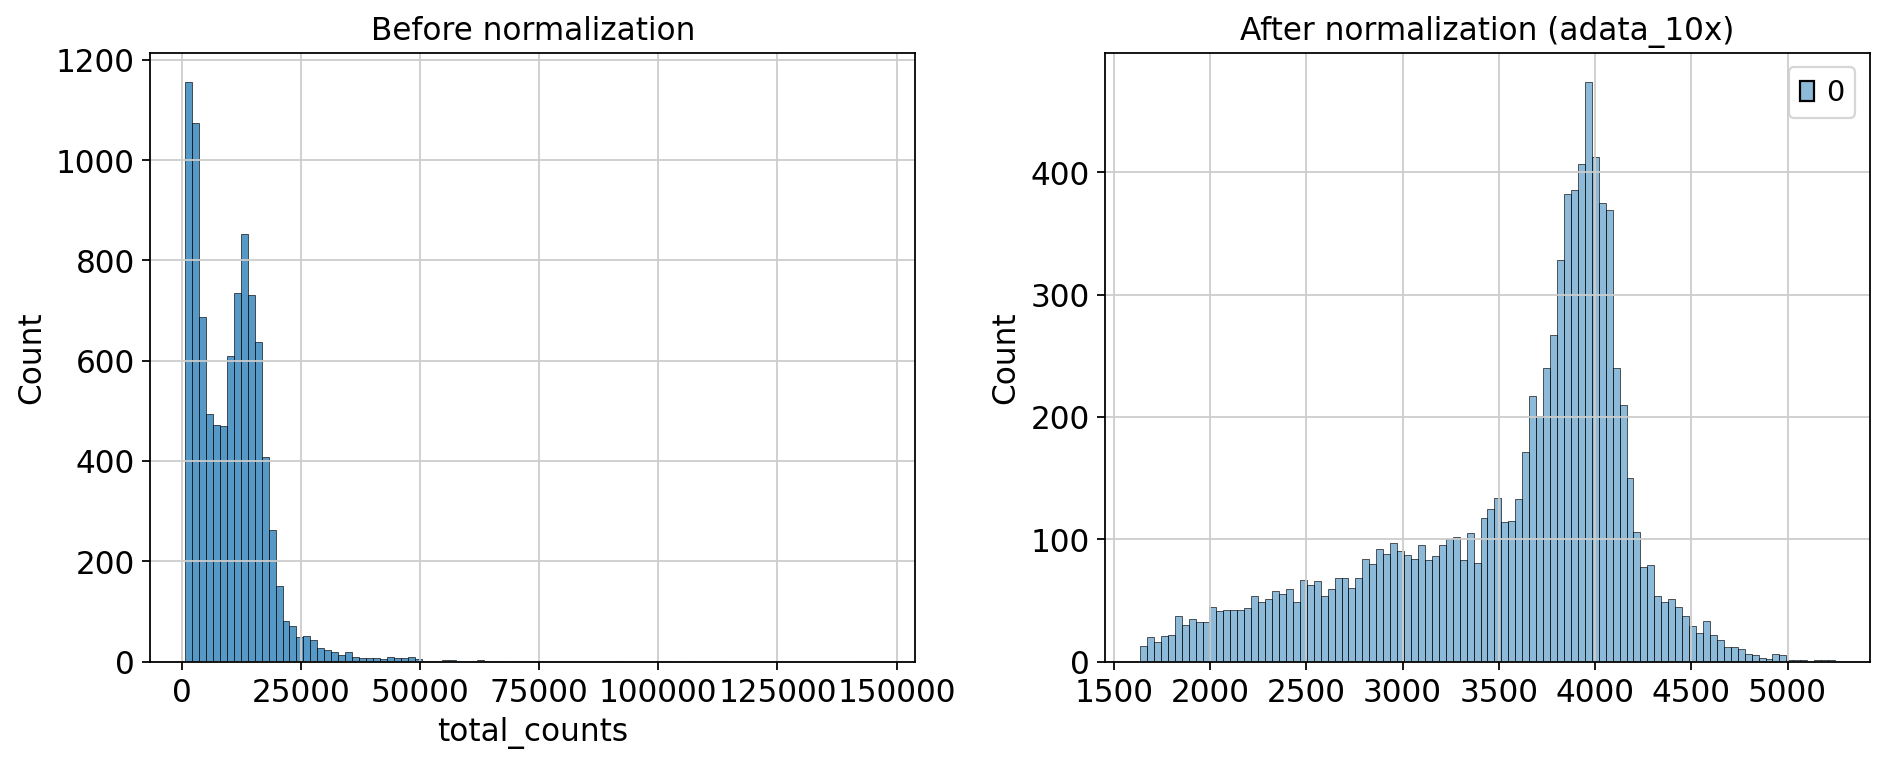

Before normalization (adata_final):


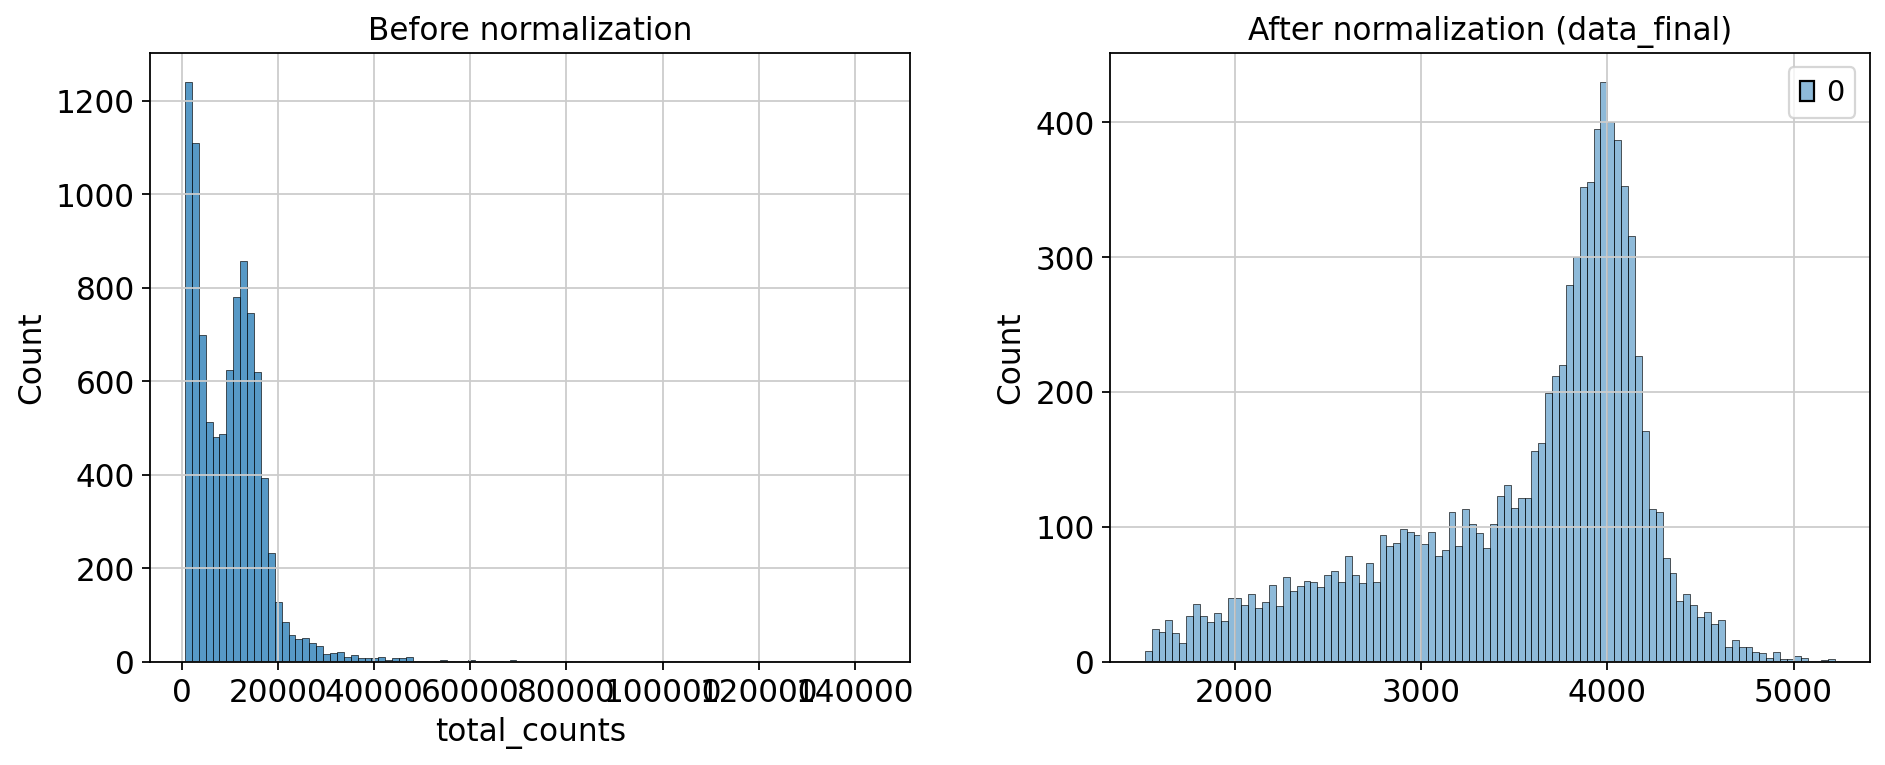

In [25]:
print("Before normalization (adata_10x):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_10x.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_10x, target_sum=None)
sc.pp.log1p(adata_10x)

sns.histplot(adata_10x.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (adata_10x)")

plt.tight_layout()
plt.show()

print("Before normalization (adata_final):")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata_final.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata_final, target_sum=None)
sc.pp.log1p(adata_final)

sns.histplot(adata_final.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization (data_final)")

plt.tight_layout()
plt.show()

# Feature Selection

In [26]:
sc.pp.highly_variable_genes(adata_10x, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata_final, min_mean=0.0125, max_mean=3, min_disp=0.5)

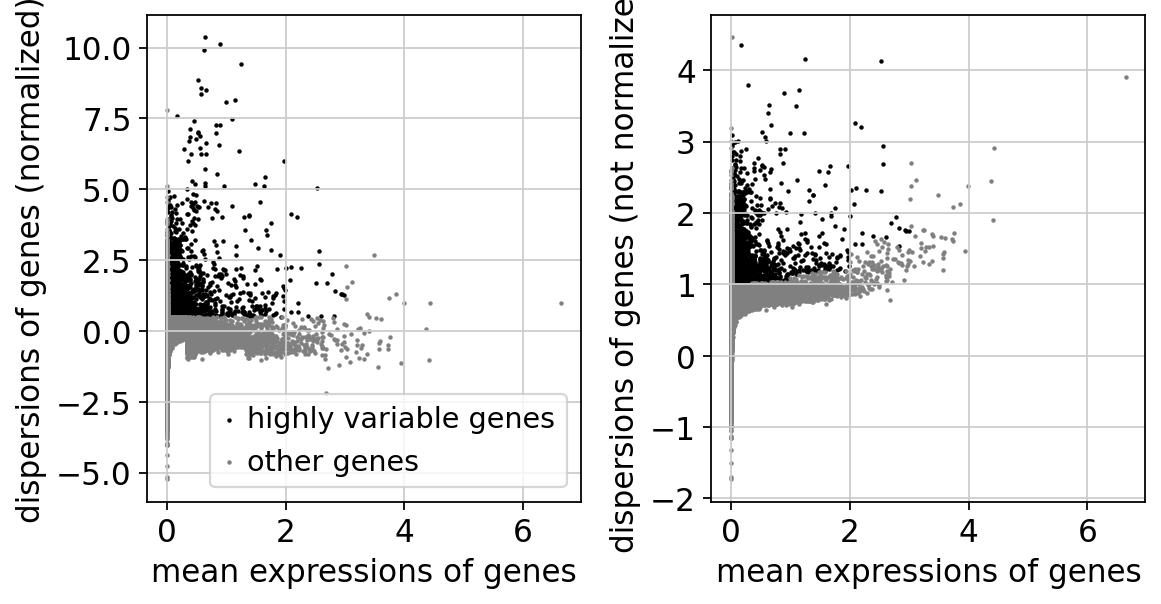

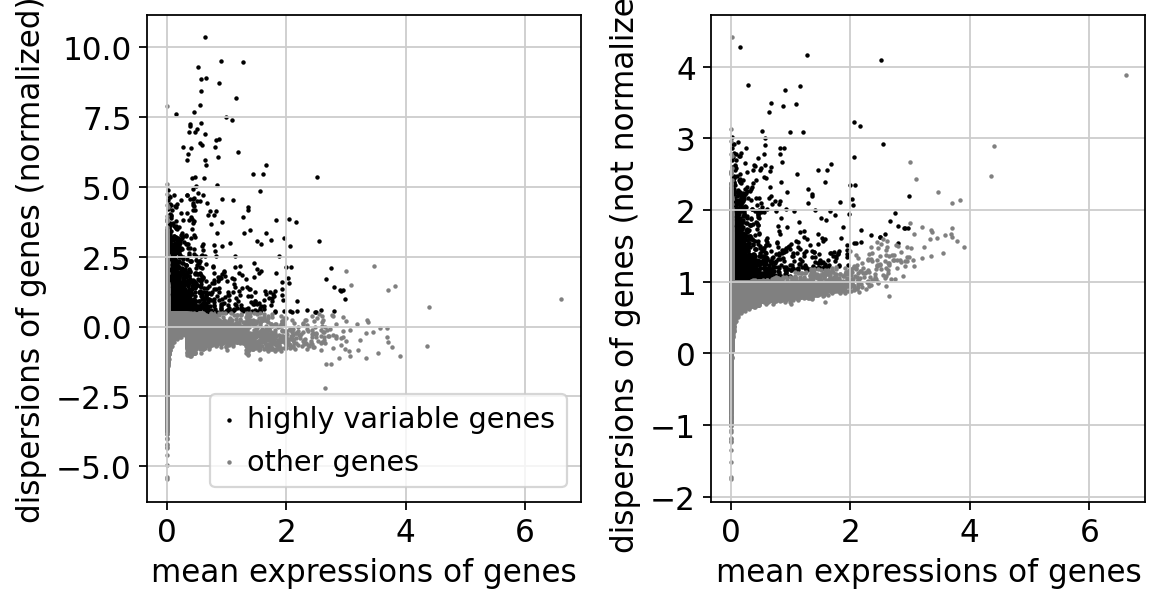

In [27]:
sc.pl.highly_variable_genes(adata_10x)
sc.pl.highly_variable_genes(adata_final)

In [28]:
# Setting this gene to highly variable to include it to further analysis
# adata.var.loc["INTERGENIC1", 'highly_variable'] = True

In [29]:
adata_10x = adata_10x[:, adata_10x.var.highly_variable]
adata_final = adata_final[:, adata_final.var.highly_variable]

In [30]:
print(adata_10x.shape)
print(adata_final.shape)

(9252, 3597)
(9398, 4382)


In [31]:
#print([gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")])

# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [32]:
sc.tl.pca(adata_10x, svd_solver='arpack')
sc.tl.pca(adata_final, svd_solver='arpack')

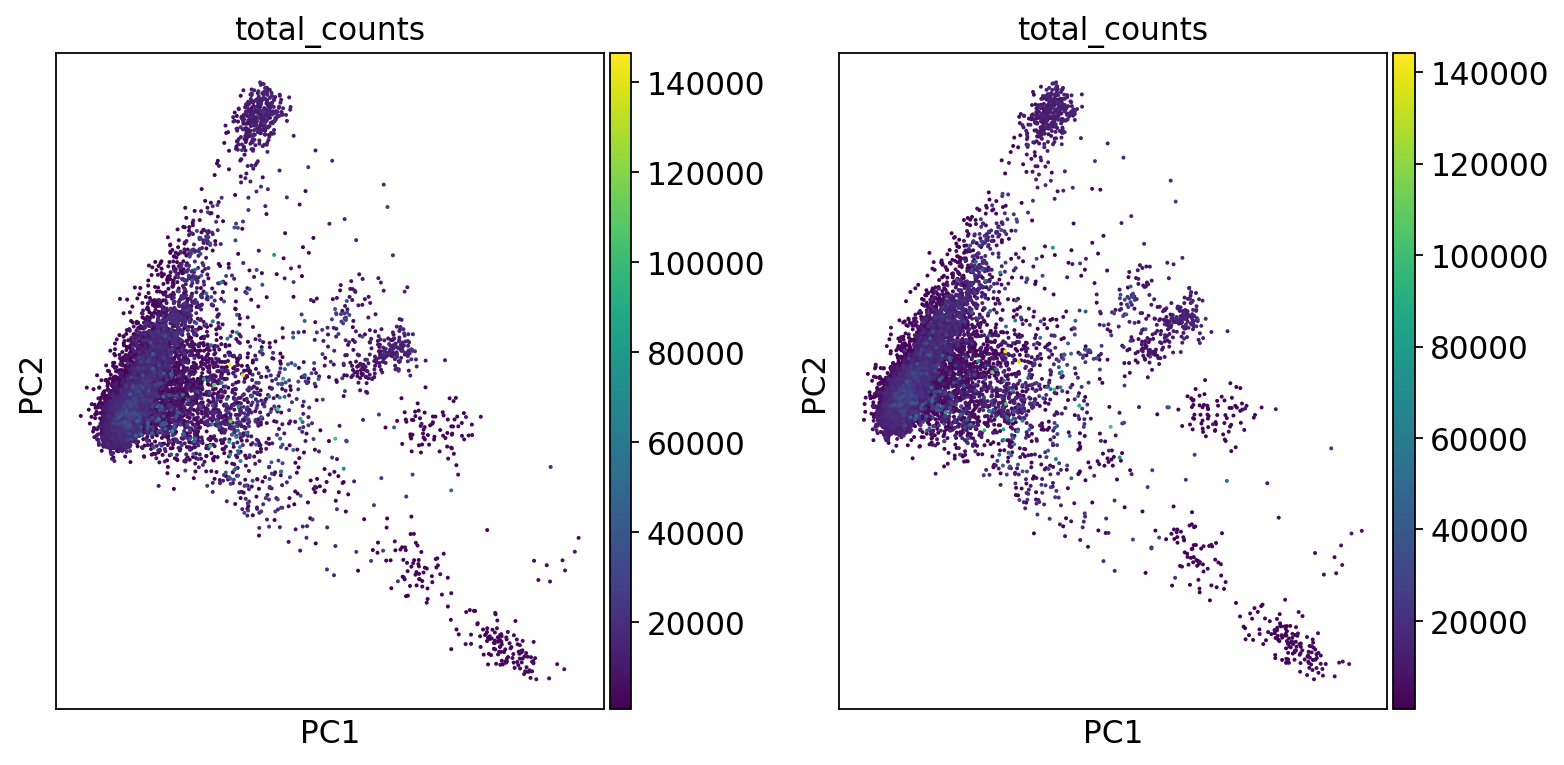

In [33]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

sc.pl.pca(adata_10x, color='total_counts', show=False, ax = axs[0])
sc.pl.pca(adata_final, color='total_counts', show=False, ax = axs[1])

plt.tight_layout()
plt.show()

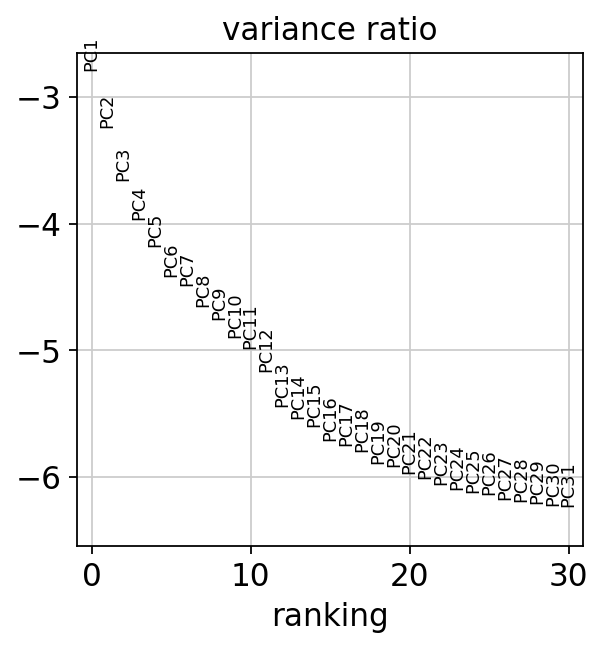

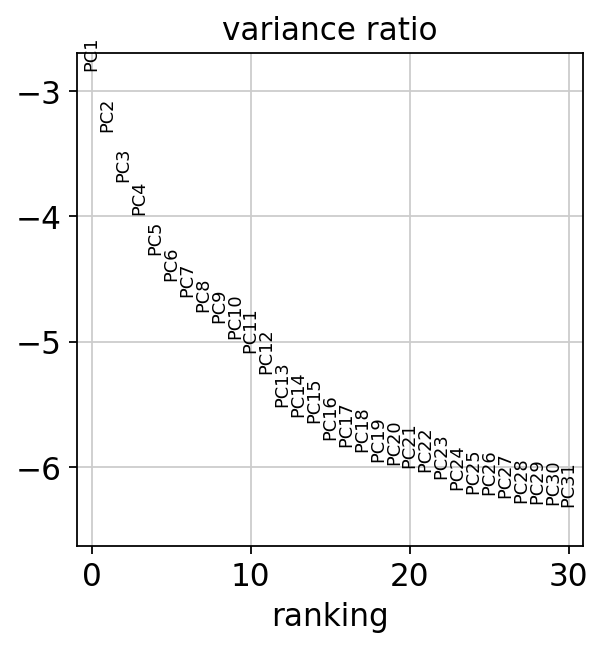

In [34]:
sc.pl.pca_variance_ratio(adata_10x, log=True)
sc.pl.pca_variance_ratio(adata_final, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [35]:
sc.tl.tsne(adata_10x, n_pcs = 7)
sc.tl.tsne(adata_final, n_pcs = 7)

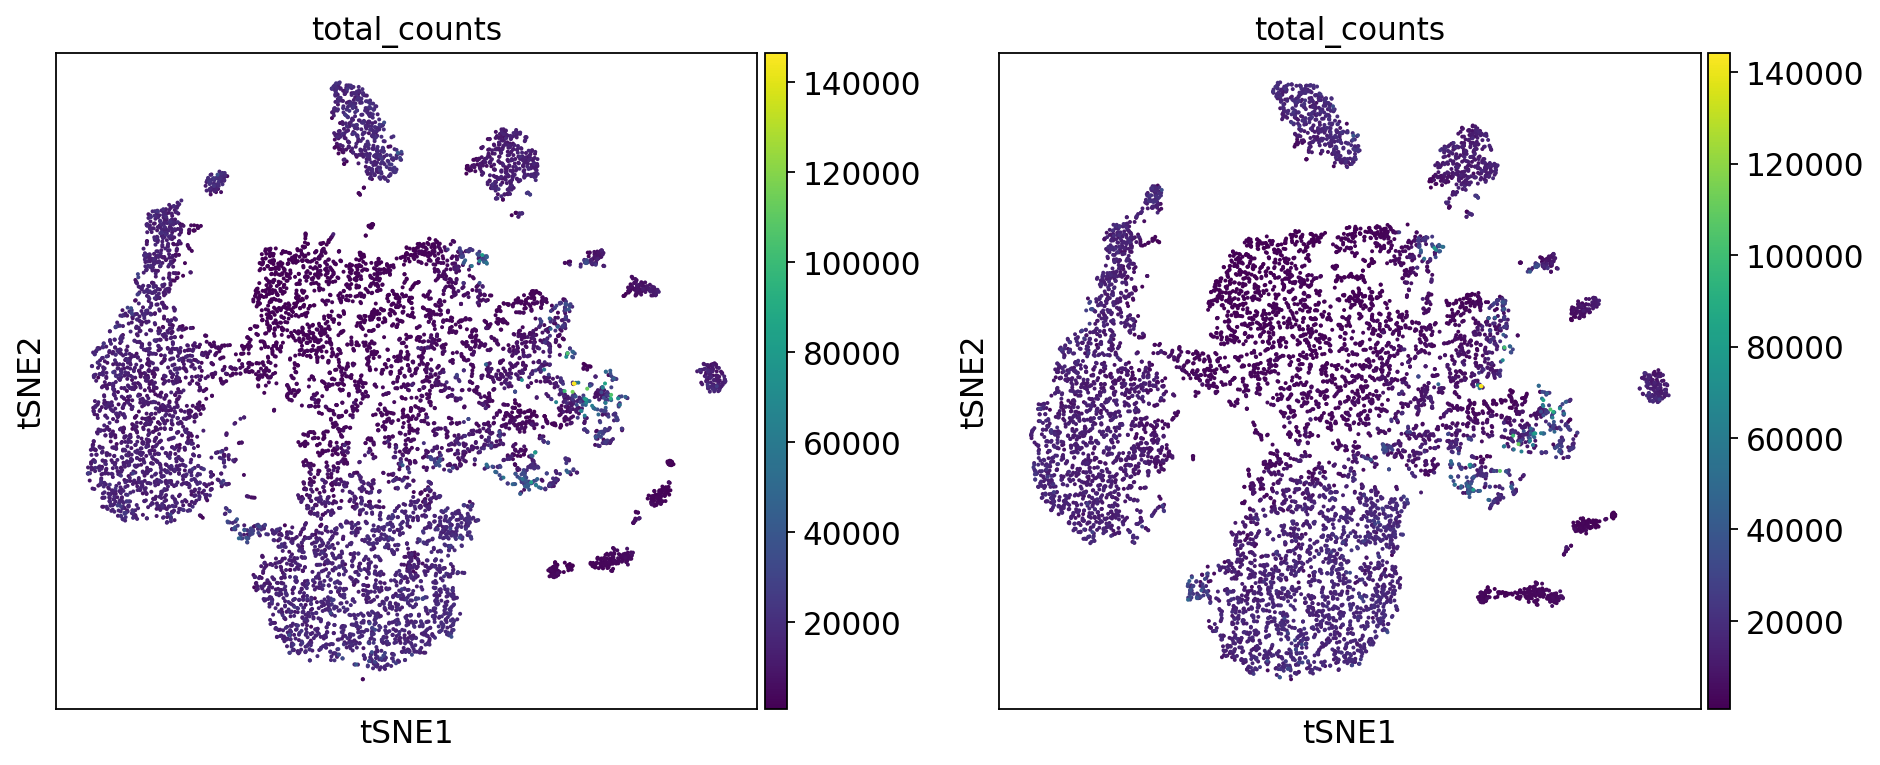

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

sc.pl.tsne(adata_10x, color="total_counts", show=False, ax=axs[0])
sc.pl.tsne(adata_final, color="total_counts", show=False, ax=axs[1])

plt.tight_layout()
plt.show()

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [37]:
sc.pp.neighbors(adata_10x, n_pcs = 7)
sc.tl.umap(adata_10x)

sc.pp.neighbors(adata_final, n_pcs = 7)
sc.tl.umap(adata_final)

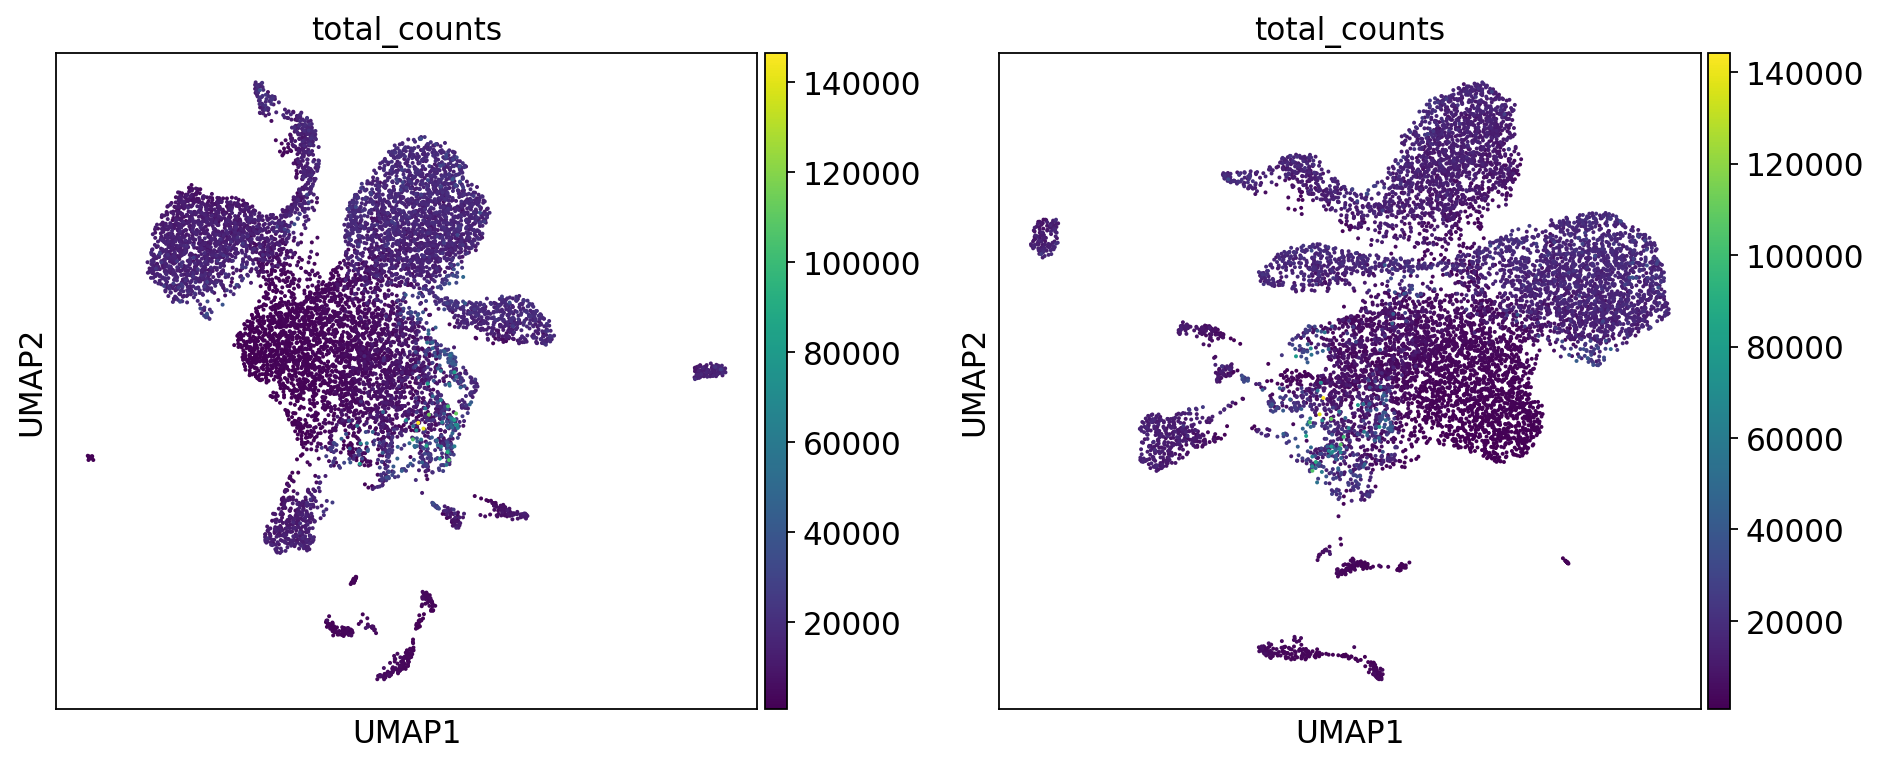

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

sc.pl.umap(adata_10x, color="total_counts", show=False, ax = axs[0])
sc.pl.umap(adata_final, color="total_counts", show=False, ax = axs[1])

plt.tight_layout()
plt.show()

# Clustering

Now let's use some cluster algorithms to separate different (sub)types of cells. We can roughly see different groups visually in the graphs of reduced dimension above. However, using various developed algorithms is more precise way to do that. Here we will use Leiden algorithm.

In [39]:
sc.tl.leiden(adata_10x, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_10x, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_10x, resolution=2, key_added="leiden2")

sc.tl.leiden(adata_final, resolution=1, key_added="leiden1")
sc.tl.leiden(adata_final, resolution=0.5, key_added="leiden05")
sc.tl.leiden(adata_final, resolution=2, key_added="leiden2")

10x


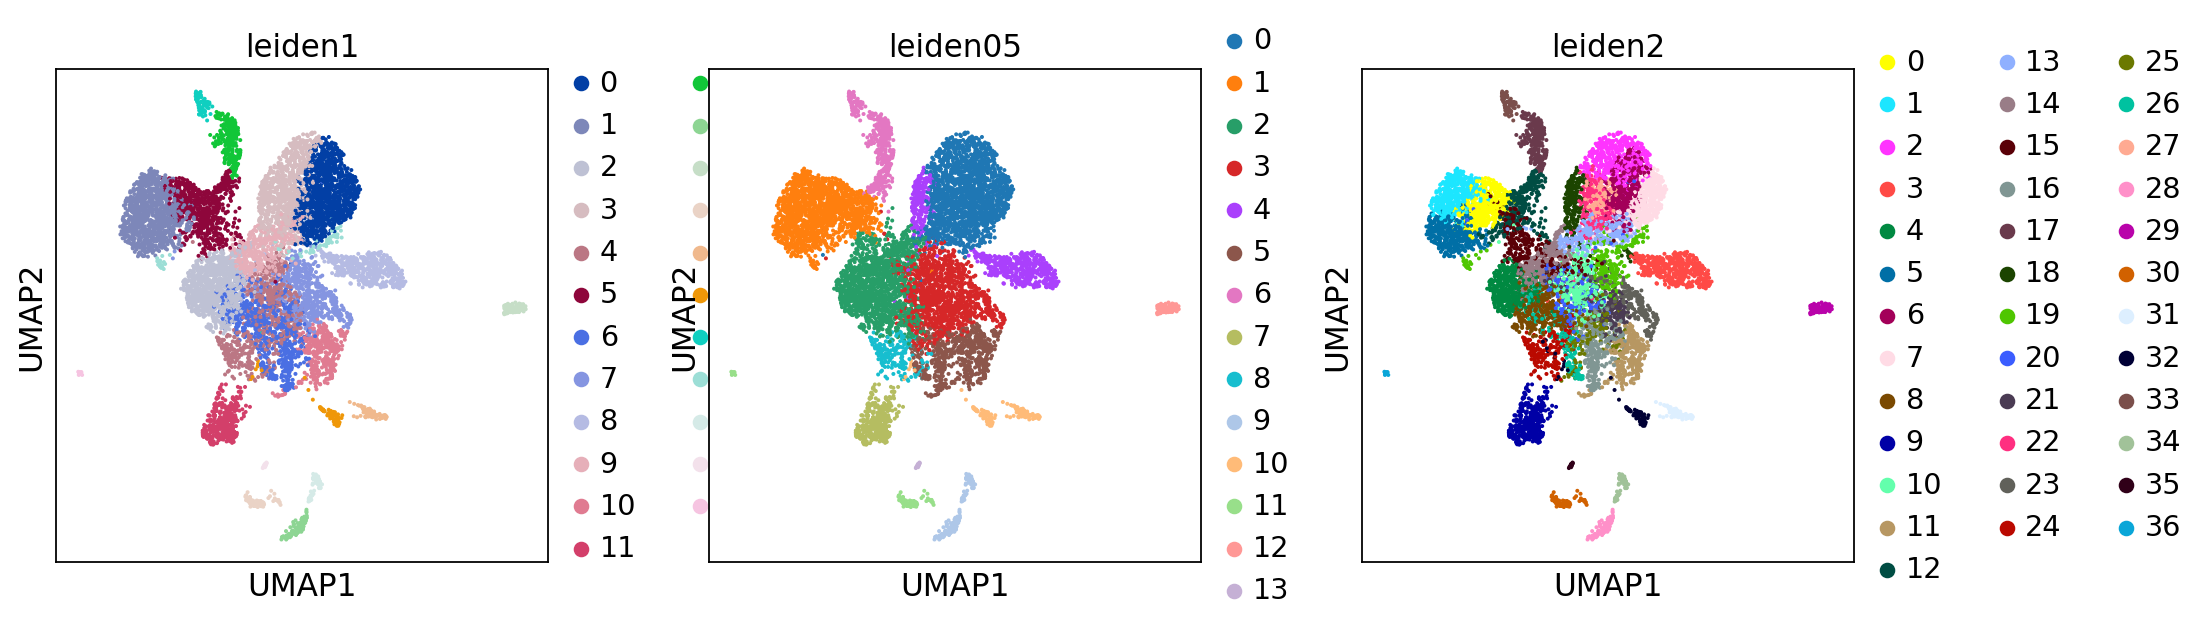

In [40]:
print("10x")
sc.pl.umap(adata_10x, color=['leiden1', 'leiden05', 'leiden2'])

final


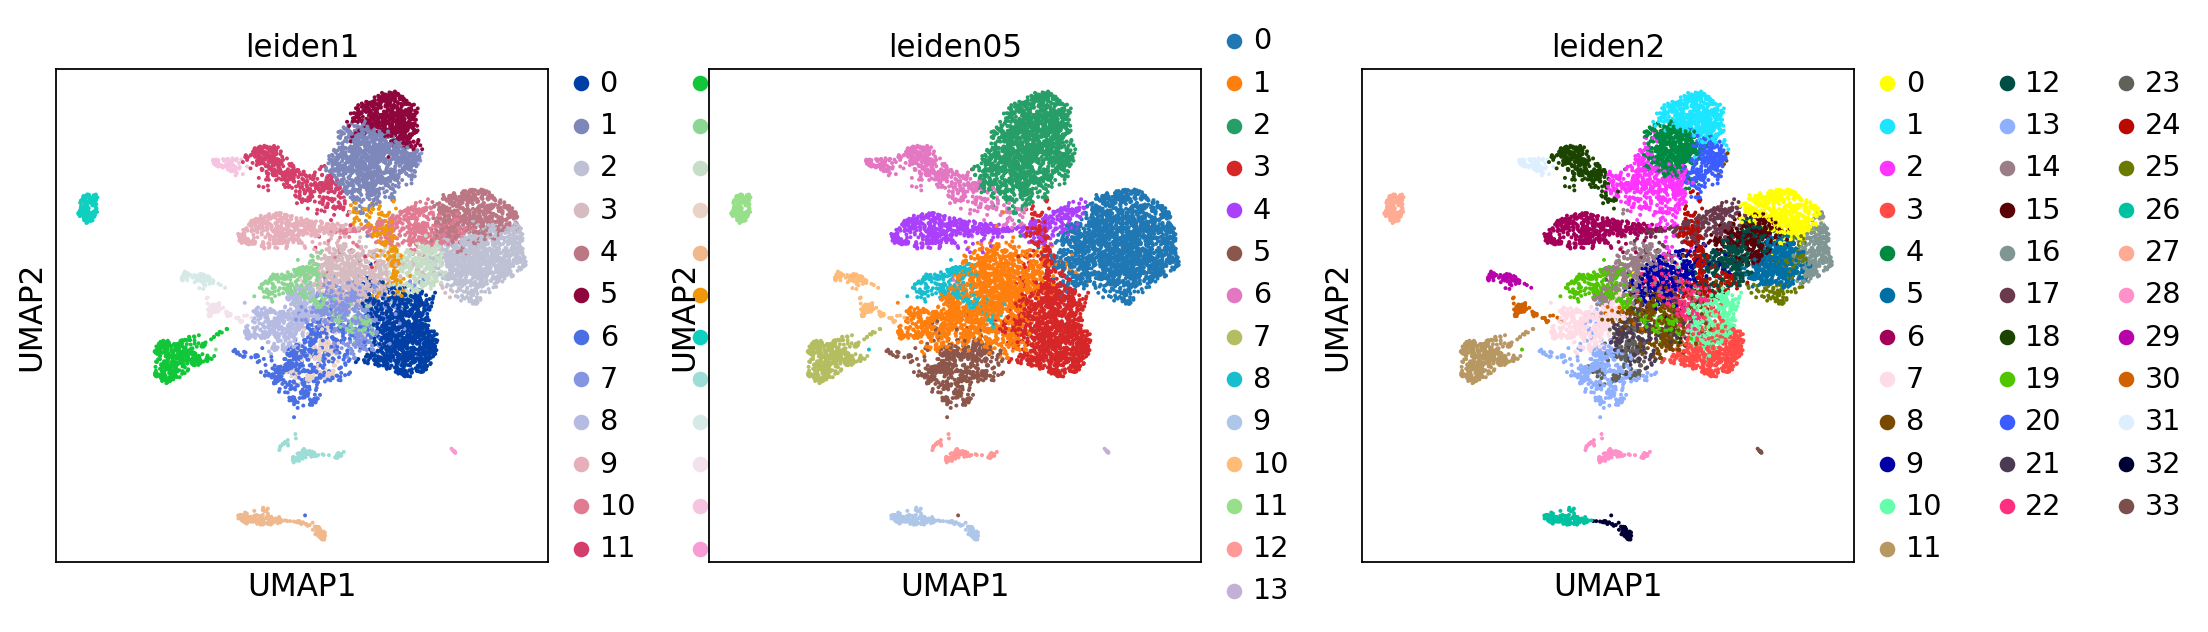

In [41]:
print("final")
sc.pl.umap(adata_final, color=['leiden1', 'leiden05', 'leiden2'])

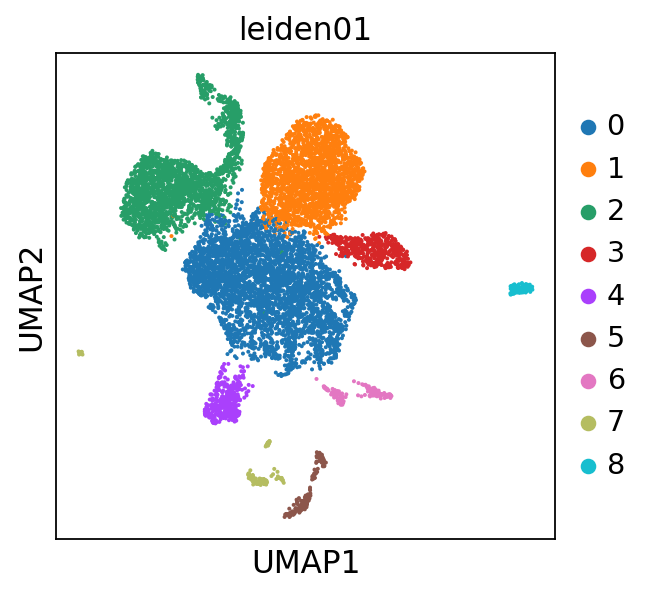

In [42]:
sc.tl.leiden(adata_10x, resolution=0.1, key_added="leiden01")
sc.pl.umap(adata_10x, color='leiden01')

# Annotation

## Automatic annotation

In [43]:
import celltypist
from celltypist import models

In [44]:
def CellTypist(adata):
    models.download_models(force_update=True, model=["Human_Longitudinal_Hippocampus.pkl", "Developing_Human_Brain.pkl"])
    model_low = models.Model.load(model="Human_Longitudinal_Hippocampus.pkl")
    model_high = models.Model.load(model="Developing_Human_Brain.pkl")
    
    adata_celltypist = adata.copy()
    adata_celltypist.X = adata.layers["celltypist"]
    sc.pp.normalize_total(adata_celltypist, target_sum = 10000)
    sc.pp.log1p(adata_celltypist)
    adata_celltypist.X = adata_celltypist.X.toarray()

    predictions_high = celltypist.annotate(adata_celltypist, model=model_high, majority_voting=True)
    predictions_high_adata = predictions_high.to_adata()
    adata.obs["celltypist_cell_label_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_coarse"] = predictions_high_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_coarse", "celltypist_conf_score_coarse"],
        frameon=False,
        sort_order=False,
        wspace=1,
        legend_loc = "on data")
    
    predictions_low = celltypist.annotate(adata_celltypist, model=model_low, majority_voting=True)
    predictions_low_adata = predictions_low.to_adata()
    adata.obs["celltypist_cell_label_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "majority_voting"]
    adata.obs["celltypist_conf_score_fine"] = predictions_low_adata.obs.loc[
        adata.obs.index, "conf_score"]
    sc.pl.umap(adata,
        color=["celltypist_cell_label_fine", "celltypist_conf_score_fine"],
        frameon=False,
        sort_order=False,
        wspace=1)

In [45]:
#CellTypist(adata_10x)
#CellTypist(adata_final)

# INTERGENIC

In [46]:
sc.settings.figdir = "../../images/umap_images_intergenic_regions/brain/highly_variable/"

for gene in [gene for gene in adata_final.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, use_raw = False, show=False, save=f"{gene}.png")

In [47]:
sc.settings.figdir = "../../images/umap_images_intergenic_regions/brain/all/"

for gene in [gene for gene in adata_final.raw.var_names if gene.startswith("INTERGENIC")]:
    sc.pl.umap(adata_final, color=gene, use_raw = True, save=f"{gene}.png", show=False)

In [48]:
#sc.pl.umap(adata_final, color="INTERGENIC41", show=True)

In [49]:
adata_final.write("../../data/downstream/adatas/brain_final.h5ad")
adata_10x.write("../../data/downstream/adatas/brain.h5ad")

... storing 'feature_types' as categorical
... storing 'feature_types' as categorical


## Loading data

In [50]:
# Loading cell-gene matrices:
adata = sc.read_10x_mtx('../../data/downstream/matrices/brain/final/')

In [51]:
adata = adata[:, adata.var_names.str.startswith("INTERGENIC")].copy()

In [52]:
print(adata.X.sum())

2031776.0


In [53]:
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 3912523 × 2210
    var: 'gene_ids', 'feature_types'


# Quality control

Firstly let's compute various metrics, which we will later use

In [54]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=True, inplace=True)

In [55]:
print(adata)

AnnData object with n_obs × n_vars = 3912523 × 2210
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


## Filtering

Barcodes with very low counts may represent empty droplets, we need to filter them out.  
Let's visualize counts per cell and set tresholds to filter low quality cells:

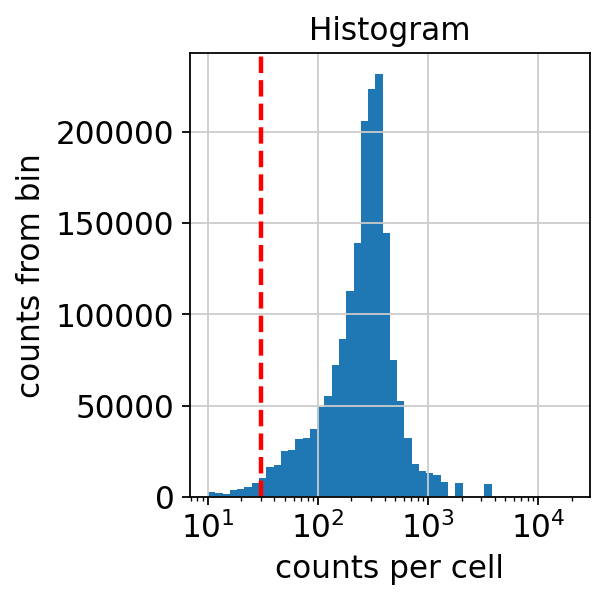

In [56]:
bins = np.logspace(np.log10(10),np.log10(20000),51)

# histograms:
plt.hist(adata.obs["total_counts"], bins = bins, weights = adata.obs["total_counts"])
plt.xscale('log')
plt.ylabel("counts from bin")
plt.xlabel("counts per cell")
plt.title("Histogram")

# tresholds (set manually):
plt.axvline(x=30, color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

So let's filter cells based on the above treshholds:

In [57]:
cmask = adata.obs['total_counts'].values>30
adata = adata[cmask]

print(adata.shape)

(9350, 2210)


Filtering low expression genes:

In [58]:
# Filtering low expression genes:
sc.pp.filter_genes(adata, min_cells=3)

In [59]:
print(adata.shape)

(9350, 2210)


Let's filter low quality cells. We will use automatic thresholding via MAD (median absolute deviations). The MAD is given by $ MAD = median(|X_i - median(X)|) $, with $X_i$ being the respective QC metric of an observation and describes a robust statistic of the variability of the metric. I will mark cells as outliers if they differ by 5 MADs which is a relatively permissive filtering strategy.

In [60]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

We will use thresholds on "log1p_total_counts", "log1p_n_genes_by_counts" and "pct_counts_mt", as abnormalities in these metrics might correspond to dying cells (e.g. if a membrane of a cell is damaged, cytoplasmic RNA migth leak out, while mitochondrial RNA remains for longer time, resulting in high percentage of mitochondrial genes and low total counts). We apply stricter thresholds for mitochondrial genes.

In [61]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
)

In [62]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier)].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 9350
Number of cells after filtering of low quality cells: 9350


## Doublets Detections

In some rare cases, we can have two cells in one droplet, leading to so called "doublets". To overcome this problem, we need to filter out those barcodes. We will use the method called Scrublet.

In [63]:
sc.external.pp.scrublet(adata)

In [64]:
cmask = adata.obs['predicted_doublet'].values == False
adata = adata[cmask]

In [65]:
print(adata.shape)

(9346, 2210)


## Visualisation

Plotting highest expression genes:

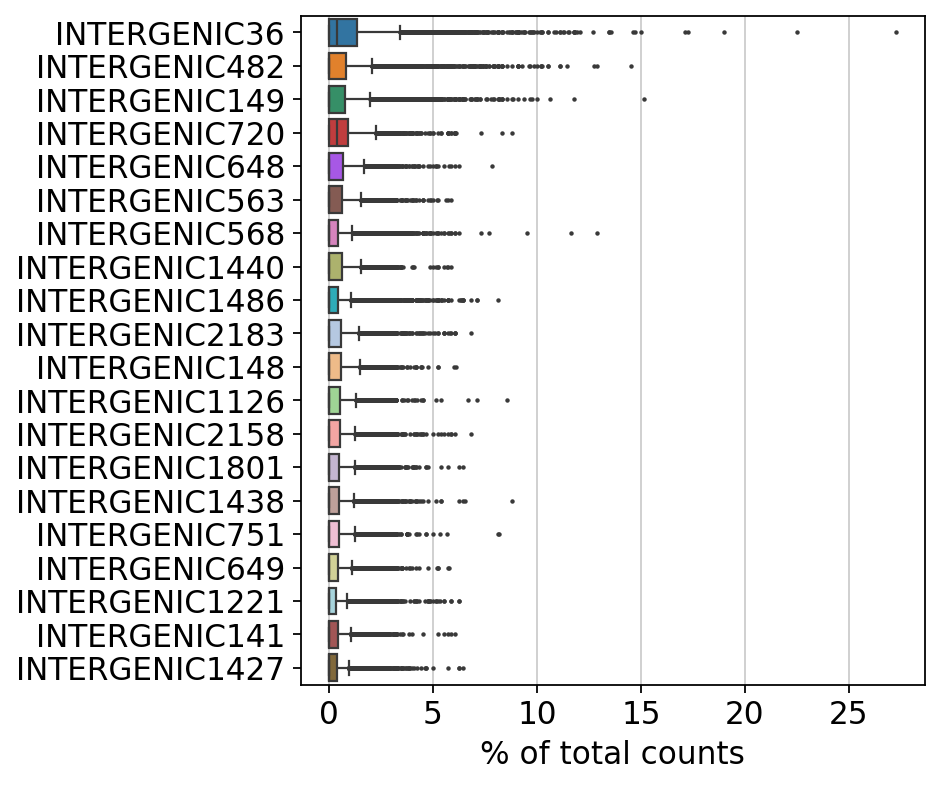

<Figure size 320x320 with 0 Axes>

In [66]:
%matplotlib inline

sc.pl.highest_expr_genes(adata, n_top=20, show=True)

plt.tight_layout()
plt.show()

... storing 'feature_types' as categorical


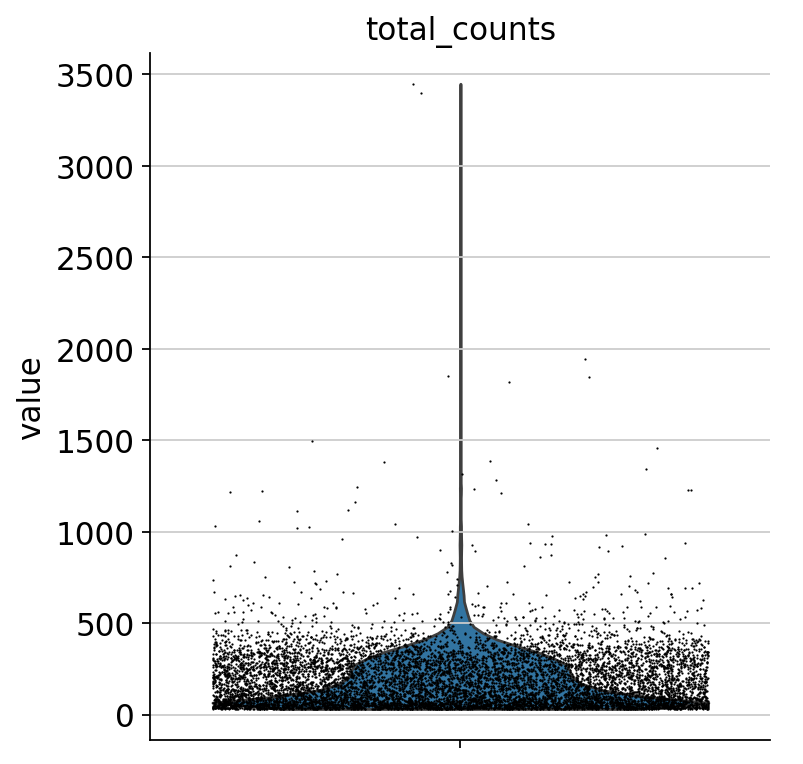

In [67]:
sc.pl.violin(adata, keys=['total_counts'], jitter=0.4, multi_panel=True)

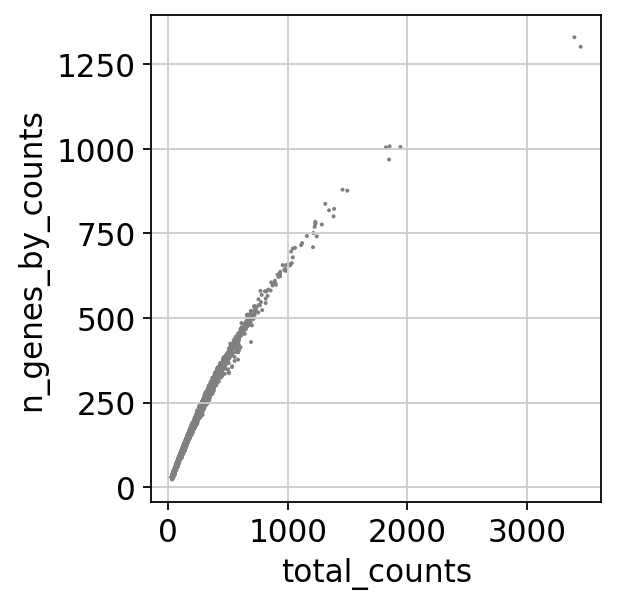

In [68]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=True)

# Normalization

Differences in count data between cells migth be the result due to sampling effects. Hence before proceeding with analysis, we need to normilize data. There are several normalization techniques (e.g. the shifted logarithm transformation, scran normalization and analytic approximation of Pearson residuals), each are well suited for different tasks. Here we will use shifted logarithm transformation, which works well for stabilizing variance for subsequent dimensionality reduction and identification of differentially expressed genes.

Before normalization:


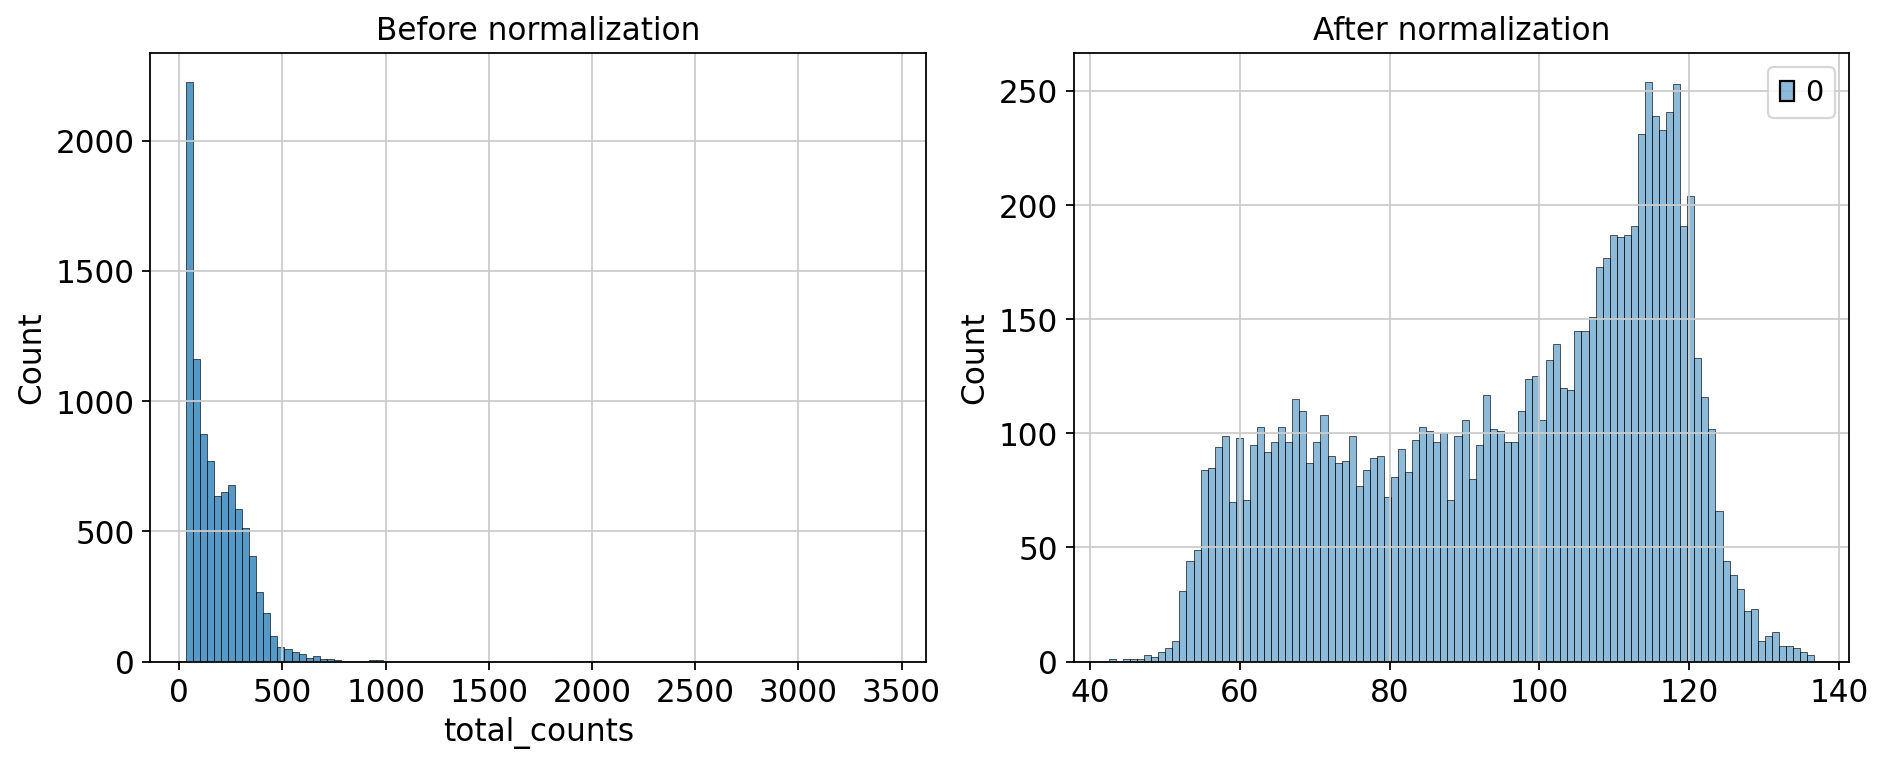

In [69]:
print("Before normalization:")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Before normalization")

sc.pp.normalize_total(adata, target_sum=None)
sc.pp.log1p(adata)

sns.histplot(adata.X.sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("After normalization")

plt.tight_layout()
plt.show()

# Feature Selection

In [70]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

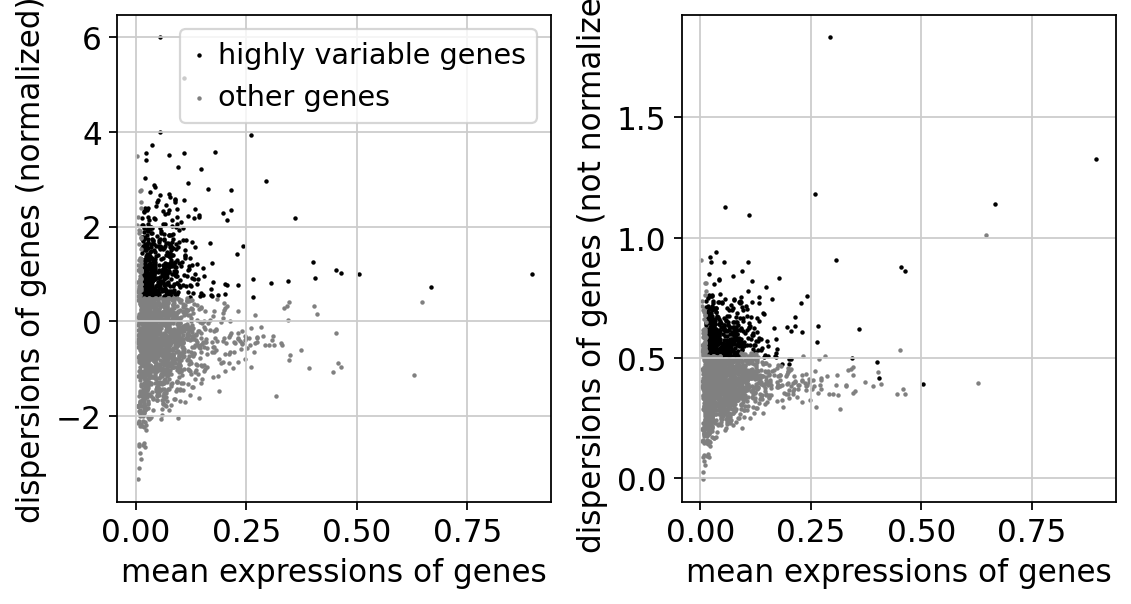

In [71]:
sc.pl.highly_variable_genes(adata)

In [72]:
adata = adata[:, adata.var.highly_variable]

In [73]:
print(adata.shape)

(9346, 550)


# Dimensionality reduction

## PCA

PCA is common strategy to construct the new set of variables with decreasing variance. In scRNA analysis, it is usually not used for clustering, instead, it is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

In [74]:
sc.tl.pca(adata, svd_solver='arpack')

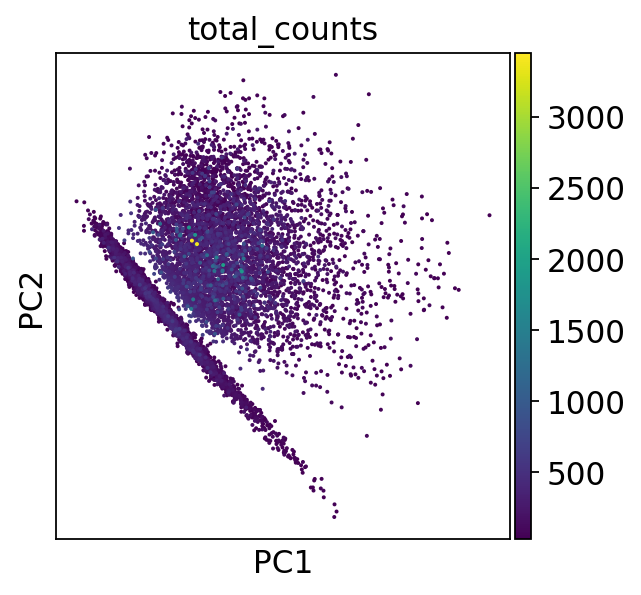

In [75]:
sc.pl.pca(adata, color='total_counts', show=True)

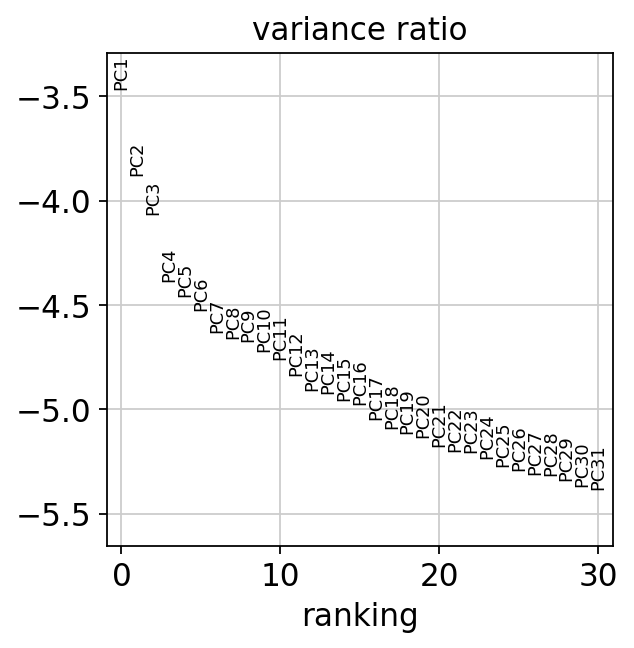

In [76]:
sc.pl.pca_variance_ratio(adata, log=True)

## t-SNE

t-SNE is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components.

In [77]:
sc.tl.tsne(adata, n_pcs = 5)

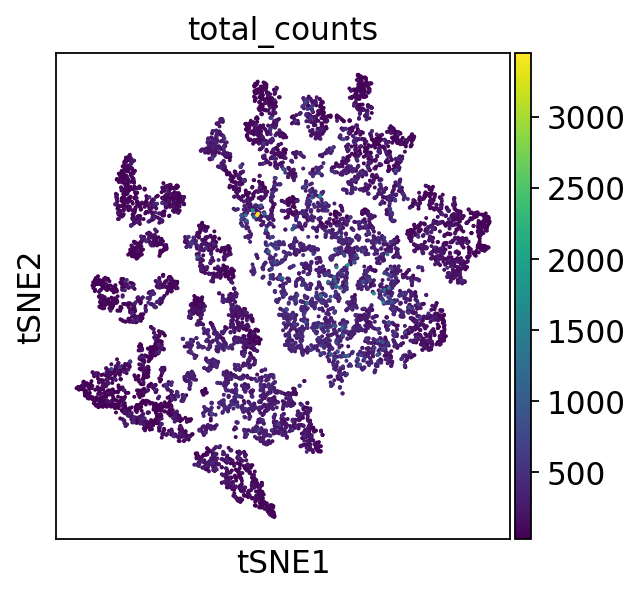

In [78]:
sc.pl.tsne(adata, color="total_counts", show=True)

## UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. To use UMAP, we firstly need to compute PCA and neighbours:

In [79]:
sc.pp.neighbors(adata, n_pcs = 5)
sc.tl.umap(adata)

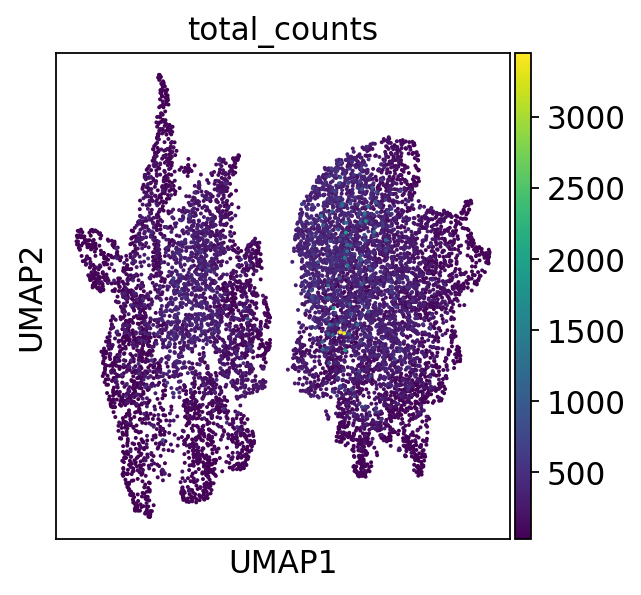

In [80]:
sc.pl.umap(adata, color="total_counts", show=True)

# INTERGENIC

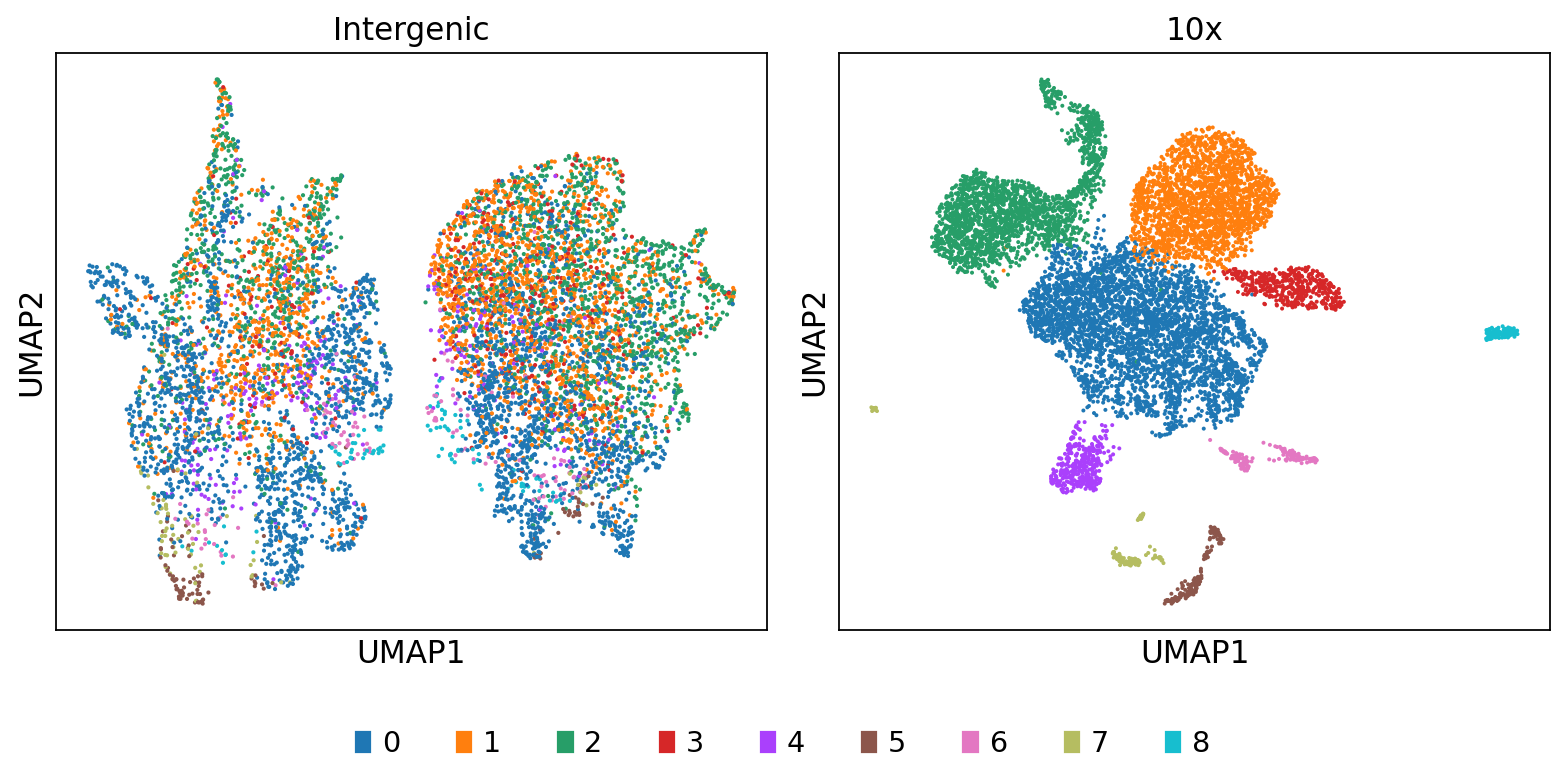

In [81]:
adata.obs['leiden01'] = adata_10x.obs['leiden01'].reindex(adata.obs_names)
adata = adata[~adata.obs['leiden01'].isna()].copy()

adata_10x.obs['leiden01'] = adata_10x.obs['leiden01'].cat.set_categories(adata.obs['leiden01'].cat.categories)
adata.uns['leiden01_colors'] = adata_10x.uns['leiden01_colors']

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(adata, color='leiden01', title='Intergenic', show=False, ax=axes[0], legend_loc=None)
sc.pl.umap(adata_10x, color='leiden01', title='10x', show=False, ax=axes[1], legend_loc=None)

# Create a custom legend
import matplotlib.patches as mpatches
colors = adata.uns['leiden01_colors']
labels = adata.obs['leiden01'].cat.categories
legend_patches = [mpatches.Patch(color=colors[i], label=label) for i, label in enumerate(labels)]

# Add the legend below both subplots
fig.legend(handles=legend_patches, loc='lower center', ncol=len(labels), frameon=False)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for the legend
plt.savefig("../../images/umaps/intergenic_10x_brain.png", dpi=300)
plt.show()

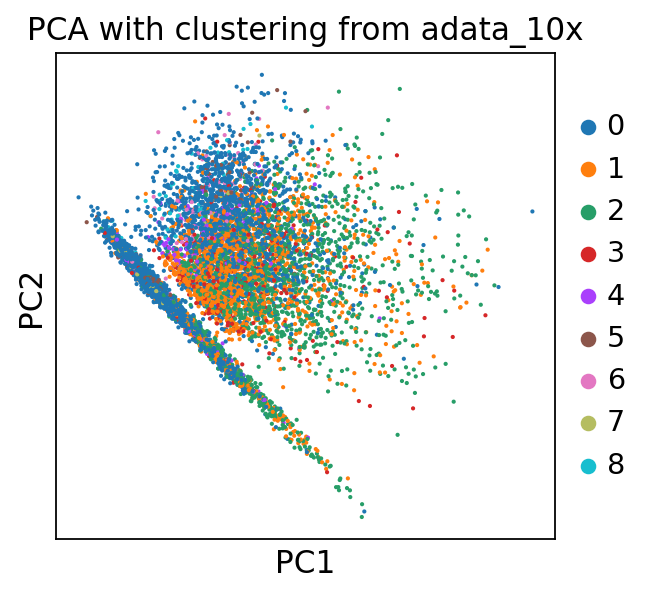

In [82]:
sc.pl.pca(adata, color='leiden01', title='PCA with clustering from adata_10x')

In [83]:
adata.write("../../data/downstream/adatas/brain_intergenic.h5ad")

# Checking PCAs

In [82]:
# Loadings for all PCs
loadings = adata.varm['PCs']

# Loadings for PC1 and PC2
pc1_loadings = loadings[:, 0]  # First PC
pc2_loadings = loadings[:, 1]  # Second PC

In [83]:
top_genes_pc1 = adata.var_names[np.argsort(-np.abs(pc1_loadings))[:10]]  # Top 10 genes
print("Top genes for PC1:", top_genes_pc1)

Top genes for PC1: Index(['INTERGENIC36', 'INTERGENIC482', 'INTERGENIC568', 'INTERGENIC1486',
       'INTERGENIC2069', 'INTERGENIC1247', 'INTERGENIC1438', 'INTERGENIC679',
       'INTERGENIC99', 'INTERGENIC1221'],
      dtype='object')


In [84]:
top_genes_pc2 = adata.var_names[np.argsort(-np.abs(pc2_loadings))[:10]]  # Top 10 genes
print("Top genes for PC2:", top_genes_pc2)

Top genes for PC2: Index(['INTERGENIC36', 'INTERGENIC482', 'INTERGENIC568', 'INTERGENIC1486',
       'INTERGENIC99', 'INTERGENIC679', 'INTERGENIC1438', 'INTERGENIC2069',
       'INTERGENIC1247', 'INTERGENIC1299'],
      dtype='object')


In [85]:
# PCA scores for all cells
pca_scores = adata.obsm['X_pca']

# Scores for PC1 and PC2
pc1_scores = pca_scores[:, 0]
pc2_scores = pca_scores[:, 1]

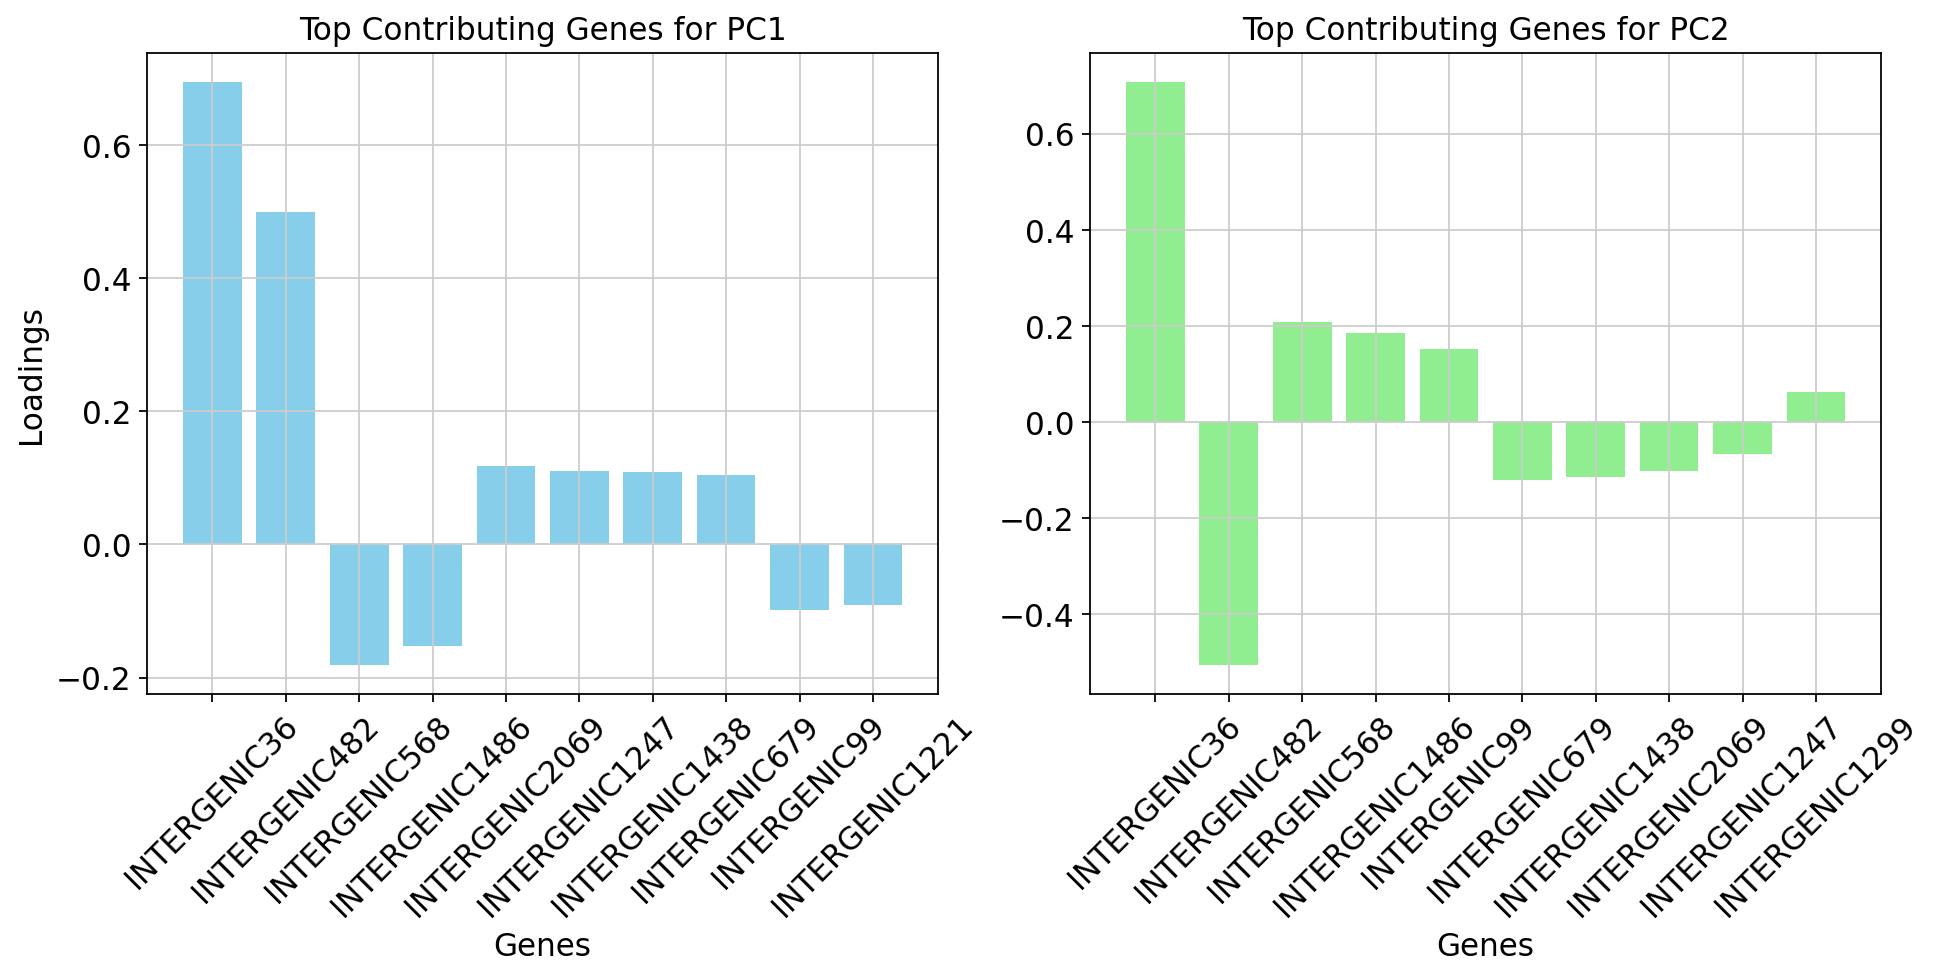

In [86]:
top_n = 10

# Get loadings for PC1 and PC2
pc1_loadings = adata.varm['PCs'][:, 0]  # PC1
pc2_loadings = adata.varm['PCs'][:, 1]  # PC2

# Get top genes for PC1 and PC2
top_genes_pc1 = adata.var_names[np.argsort(-np.abs(pc1_loadings))[:top_n]]
top_genes_pc2 = adata.var_names[np.argsort(-np.abs(pc2_loadings))[:top_n]]

# Get corresponding loadings
top_loadings_pc1 = pc1_loadings[np.argsort(-np.abs(pc1_loadings))[:top_n]]
top_loadings_pc2 = pc2_loadings[np.argsort(-np.abs(pc2_loadings))[:top_n]]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Plot PC1
axes[0].bar(top_genes_pc1, top_loadings_pc1, color='skyblue')
axes[0].set_title("Top Contributing Genes for PC1")
axes[0].set_xlabel("Genes")
axes[0].set_ylabel("Loadings")
axes[0].tick_params(axis='x', rotation=45)

# Plot PC2
axes[1].bar(top_genes_pc2, top_loadings_pc2, color='lightgreen')
axes[1].set_title("Top Contributing Genes for PC2")
axes[1].set_xlabel("Genes")
axes[1].tick_params(axis='x', rotation=45)

# Show the plots
plt.show()

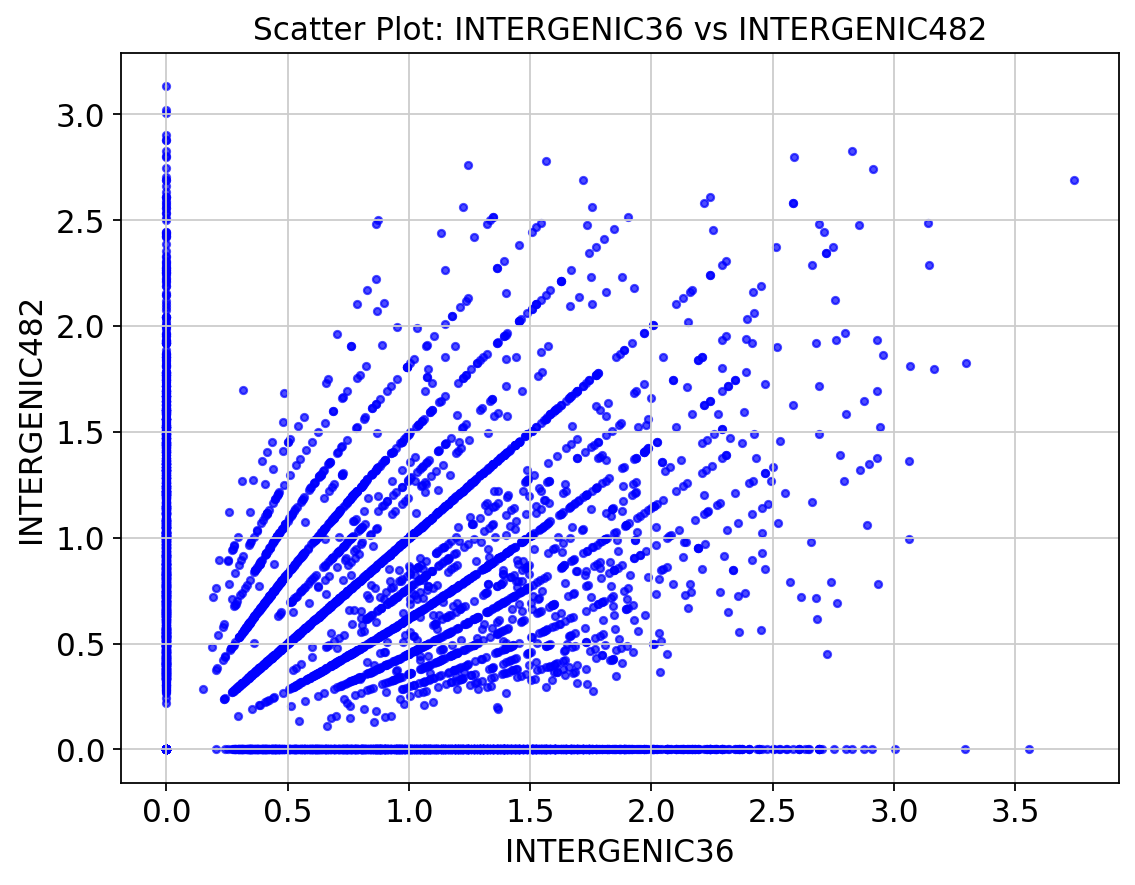

In [87]:
gene_x = "INTERGENIC36"  # Replace with your gene name
gene_y = "INTERGENIC482"  # Replace with your gene name

x_values = adata[:, gene_x].X.toarray().flatten()  # Convert to dense array and flatten
y_values = adata[:, gene_y].X.toarray().flatten()  # Convert to dense array and flatten

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, s=10, alpha=0.7, c="blue")  # Customize marker size and color
plt.xlabel(gene_x)
plt.ylabel(gene_y)
plt.title(f"Scatter Plot: {gene_x} vs {gene_y}")
plt.grid(True)
plt.show()

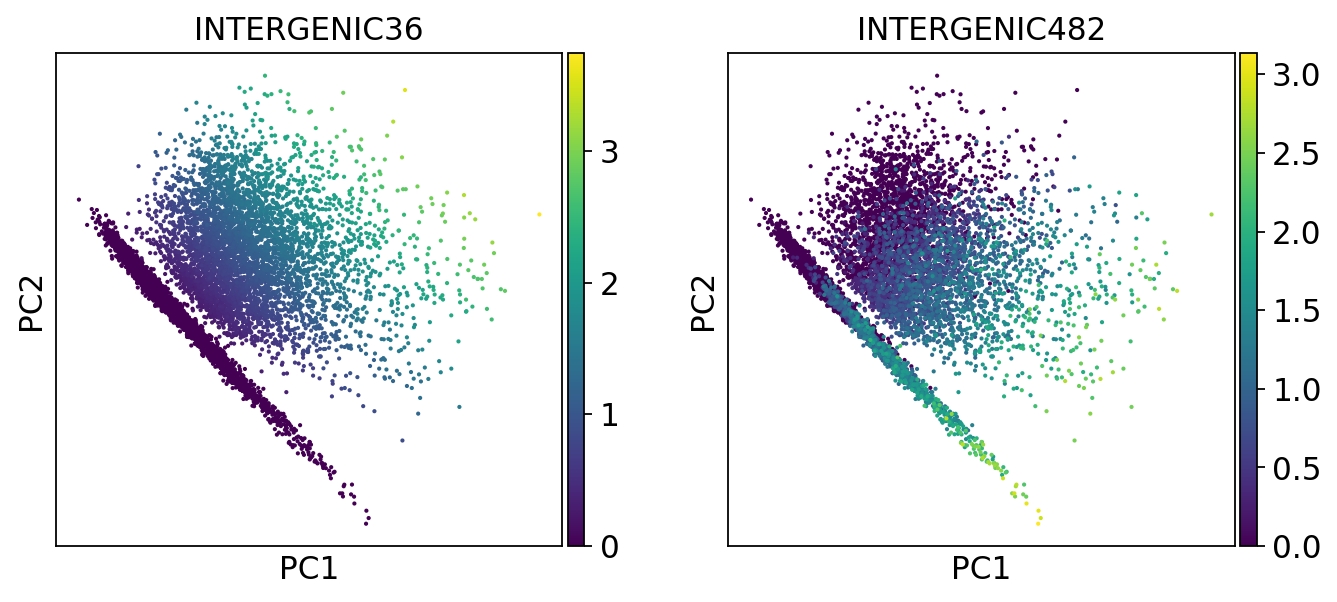

In [88]:
sc.pl.pca(adata, color = ['INTERGENIC36', 'INTERGENIC482'], show = True)